In [40]:
!git clone https://github.com/fredrikofstad/FL-Appliance-Energy-Prediction-and-Classification

Cloning into 'FL-Appliance-Energy-Prediction-and-Classification'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 301 (delta 173), reused 179 (delta 98), pack-reused 14
Receiving objects: 100% (301/301), 73.88 MiB | 28.99 MiB/s, done.
Resolving deltas: 100% (173/173), done.
time: 4.63 s (started: 2023-11-11 21:53:41 +00:00)


In [41]:
!pip install --upgrade tensorflow-federated

time: 24.3 s (started: 2023-11-11 21:53:49 +00:00)


In [42]:
!pip install ipython-autotime

time: 14 s (started: 2023-11-11 21:54:18 +00:00)


In [43]:
%cd /content/FL-Appliance-Energy-Prediction-and-Classification

/content/FL-Appliance-Energy-Prediction-and-Classification
time: 1.1 ms (started: 2023-11-11 21:54:37 +00:00)


In [44]:
!pip install tensorboard

time: 7.24 s (started: 2023-11-11 21:54:40 +00:00)


In [45]:
!pip install tensorflow

time: 4.72 s (started: 2023-11-11 21:54:55 +00:00)


In [46]:
#Load data
import pandas as pd
import os

# Directory where your CSV files are located
directory_path = 'data/'

# Dictionary to store DataFrames
dataframes = {}
name_list=[]
# Loop through each CSV file and read it into a DataFrame
for i in range(1, 51):
    file_name = f'Consumer{i}.csv'  # Construct the file name
    name_list.append(file_name)
    file_path = os.path.join(directory_path, file_name)  # Full path to the CSV file

    # Read the CSV file into a pandas DataFrame and store it in the dictionary
    dataframes[file_name] = pd.read_csv(file_path)


time: 3.01 s (started: 2023-11-11 21:55:04 +00:00)


In [47]:
variables = globals().copy()
for sheet_name, df in dataframes.items():
    variables[sheet_name] = df

time: 743 µs (started: 2023-11-11 21:55:12 +00:00)


In [48]:
variables[name_list[49]]

Unnamed: 0  Periods  AC  Dish washer  Washing Machine  Dryer  \
0               0        1   0          0.0              0.0    0.0   
1               1        2   0          0.0              0.0    0.0   
2               2        3   0          0.0              0.0    0.0   
3               3        4   0          0.0              0.0    0.0   
4               4        5   0          0.0              0.0    0.0   
...           ...      ...  ..          ...              ...    ...   
35131       35131       92   0          0.0              0.0    0.0   
35132       35132       93   0          0.0              0.0    0.0   
35133       35133       94   0          0.0              0.0    0.0   
35134       35134       95   0          0.0              0.0    0.0   
35135       35135       96   0          0.0              0.0    0.0   

       Water heater        TV  Microwave  Kettle  Lighting  Refrigerator  
0             0.000  0.000000        0.0     0.0  0.000000           0.0  
1             0.000  0.000000        0.0     0.0  0.000000           0.0  
2             0.000  0.000000        0.0     0.0  0.000000           0.0  
3             0.000  0.000000        0.0     0.0  0.000000           0.0  
4             0.000  0.000000        0.0     0.0  0.000000           0.0  
...             ...       ...        ...     ...       ...           ...  
35131         0.346  0.046792        0.0     0.0  0.219333           0.0  
35132         0.207  0.047054        0.0     0.0  0.217667           0.0  
35133         0.373  0.046454        0.0     0.0  0.218667           0.0  
35134         0.079  0.000000        0.0     0.0  0.063333           0.0  
35135         0.000  0.000000        0.0     0.0  0.000000           0.0  

[35136 rows x 12 columns]

time: 24 ms (started: 2023-11-11 21:55:15 +00:00)


In [49]:
#Process data split into train and test
import numpy as np
import tensorflow as tf

def func_prep_data_pred(df):
    df = df.iloc[:, 2:]
    df['energy_consumption'] = df.sum(axis=1)
    chunk_size = 96

    # Calculate the total number of chunks
    num_chunks = len(df) // chunk_size

    # Initialize an empty list to store chunks as lists
    aggregated_values = []

    # Iterate through the chunks and convert each chunk to a list
    for i in range(num_chunks):
        # Extract the chunk of data
        chunk = df.iloc[i * chunk_size: (i + 1) * chunk_size]

        # Convert the chunk to a list and append it to the list of aggregated values
        chunk_list = chunk['energy_consumption'].tolist()
        aggregated_values.append(chunk_list)

    def create_input_output_pairs(data, window_size=7):
        input_output_pairs = []
        input_output_pair_index = []
        total_days = len(data)
        for i in range(total_days - window_size):
            input_data = data[i:i+window_size]
            input_data_index = np.array(list(range(i, i + window_size)))
            output_data = data[i+window_size:i+window_size+1]
            output_data_index = np.array(list(range(i+window_size, i + window_size+1)))
            input_output_pairs.append((input_data, output_data))
            input_output_pair_index.append((input_data_index, output_data_index))

        return input_output_pairs, input_output_pair_index

    keyss = create_input_output_pairs(aggregated_values, window_size=7)

    convert_tensor_input_train = []
    for j in range(288):
        convert_to_input_matrix = np.vstack([keyss[0][j][0][i] for i in range(0, 7)])
        convert_tensor_input_train.append(convert_to_input_matrix)

    tensor_converted_input_train = tf.convert_to_tensor(convert_tensor_input_train, dtype=tf.float64)


    convert_tensor_input_test = []
    for j in range(288,359):
        convert_to_input_matrix = np.vstack([keyss[0][j][0][i] for i in range(0, 7)])
        convert_tensor_input_test.append(convert_to_input_matrix)
    tensor_converted_input_test = tf.convert_to_tensor(convert_tensor_input_test, dtype=tf.float64)


    tensor_converted_input_train = tf.transpose(tensor_converted_input_train, perm=[0, 2, 1])
    tensor_converted_input_test = tf.transpose(tensor_converted_input_test, perm=[0, 2, 1])

    convert_tensor_output_train = []
    for j in range(288):
        convert_to_output_matrix = keyss[0][j][1][0]
        convert_tensor_output_train.append(convert_to_output_matrix)

    tensor_converted_output_train = tf.convert_to_tensor(convert_tensor_output_train, dtype=tf.float64)

    convert_tensor_output_test = []
    for j in range(288,359):
        convert_to_output_matrix = keyss[0][j][1][0]
        convert_tensor_output_test.append(convert_to_output_matrix)

    tensor_converted_output_test = tf.convert_to_tensor(convert_tensor_output_test, dtype=tf.float64)

    return tensor_converted_input_train, tensor_converted_output_train,tensor_converted_input_test, tensor_converted_output_test


time: 3.71 ms (started: 2023-11-11 21:55:21 +00:00)


In [50]:

#Process all data
prediction_processed_data=[func_prep_data_pred(variables[name_list[i]]) for i in range(0,50) ]

time: 5.79 s (started: 2023-11-11 21:55:25 +00:00)


In [51]:
prediction_processed_data[0][3].shape

TensorShape([71, 96])

time: 3.71 ms (started: 2023-11-11 21:55:34 +00:00)


In [52]:
#Check shape of data
input_data_list_train=[prediction_processed_data[i][0].numpy() for i in range(50)]
target_data_list_train=[prediction_processed_data[i][1].numpy() for i in range(50)]

print(input_data_list_train[0].shape)
print(target_data_list_train[0].dtype)



(288, 96, 7)
float64
time: 106 ms (started: 2023-11-11 21:55:38 +00:00)


In [53]:
#printout of runtime printed in the end of the print
%load_ext autotime

#Federated learning for prediction
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt

np.random.seed(3)

input_data_list_train=[prediction_processed_data[i][0].numpy() for i in range(50)]
target_data_list_train=[prediction_processed_data[i][1].numpy() for i in range(50)]

# Define constants and hyperparameters
NUM_CLIENTS = len(input_data_list_train)
NUM_EPOCHS = 1
BATCH_SIZE = 96
SHUFFLE_BUFFER = 1
PREFETCH_BUFFER = 1
SEQ_LENGTH = 96
INPUT_SIZE = 7
OUTPUT_SIZE = 96

# Create a tf.data.Dataset from the loaded data
def create_tf_dataset(input_data, target_data):
    dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
    return dataset

# Create client datasets
client_datasets = []
for i in range(NUM_CLIENTS):
    dataset = create_tf_dataset(input_data_list_train[i], target_data_list_train[i])
    dataset = dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
        BATCH_SIZE).prefetch(PREFETCH_BUFFER)
    client_datasets.append(dataset)

#sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]
federated_train_data = client_datasets

def create_keras_model2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(64, input_shape=(SEQ_LENGTH, INPUT_SIZE)),
        tf.keras.layers.Dense(OUTPUT_SIZE, activation="sigmoid")
    ])
    return model


class get_true_pred(tf.keras.metrics.Metric):
    def __init__(self, name='get_true_pred', **kwargs):
        super(get_true_pred, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', shape=(BATCH_SIZE, OUTPUT_SIZE, 2), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        values = tf.cast(y_pred, 'float32'), tf.cast(y_true, 'float32')
        values = tf.stack(values, axis=-1)
        self.true_positives.assign_add(values)

    def result(self):
        return self.true_positives

    def reset_states(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))



def model_fn():
    keras_model = create_keras_model2()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError(),get_true_pred()])

training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.8),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

train_state = training_process.initialize()

#run training store metric values
y_true_y_pred_list=[]
mse_list=[]
#NUM_ROUND or EPOCH
NUM_ROUNDS = 100
for round_num in range(2, NUM_ROUNDS):
    result = training_process.next(train_state, federated_train_data)
    train_state = result.state
    train_metrics = result.metrics
    y_true_y_pred_list.append(train_metrics['client_work']["train"]['get_true_pred'])
    mse_list.append(train_metrics['client_work']["train"]['mean_squared_error'])
    print('round {:2d}, metrics={}'.format(round_num, train_metrics))


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_squared_error', 0.290961), ('get_true_pred', array([[[75.5541   ,  2.447    ],
        [71.41717  ,  7.2159996],
        [74.99407  , 10.304003 ],
        ...,
        [79.914825 , 25.372356 ],
        [69.39359  , 26.440014 ],
        [71.78582  ,  0.       ]],

       [[75.001236 ,  3.189    ],
        [78.043785 ,  4.4070005],
        [72.68401  ,  7.167999 ],
        ...,
        [78.251    , 22.236725 ],
        [70.74481  , 23.070059 ],
        [75.80043  ,  0.       ]],

       [[74.82606  ,  3.534    ],
        [75.08179  ,  5.777001 ],
        [74.22158  , 11.474998 ],
        ...,
        [75.51376  , 22.582857 ],
        [75.71935  , 23.999304 ],
        [77.14355  ,  0.       ]],

       ...,

       [[71.51901  , 10.4609995],
        [75.74084  , 14.096001 ],
        [73.12542  , 1

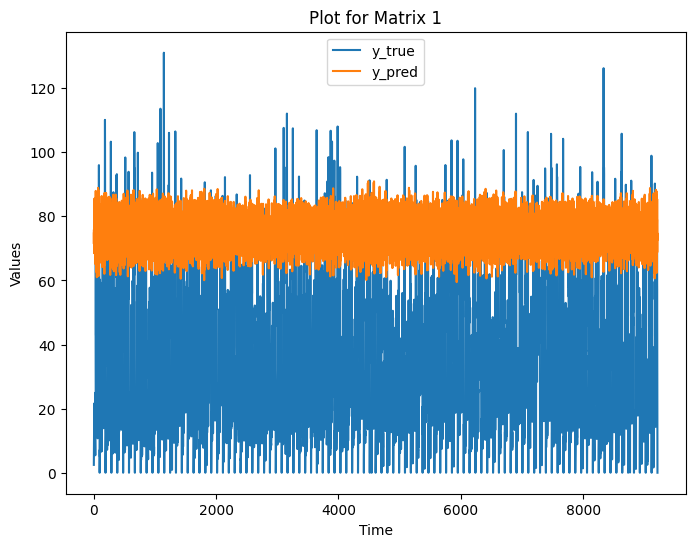

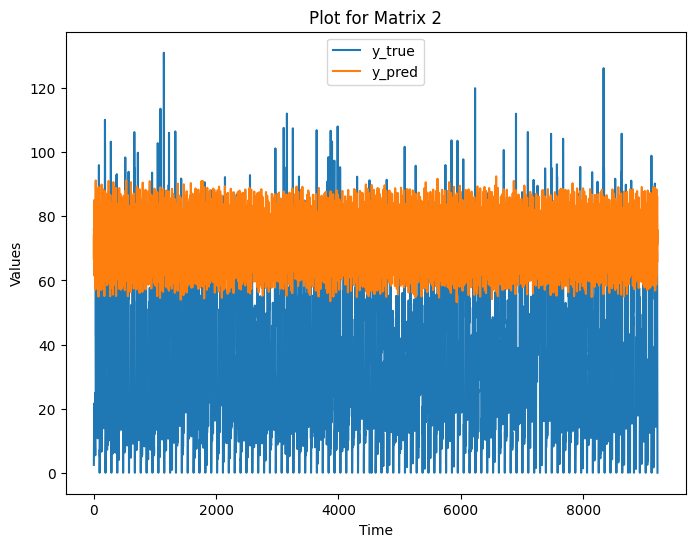

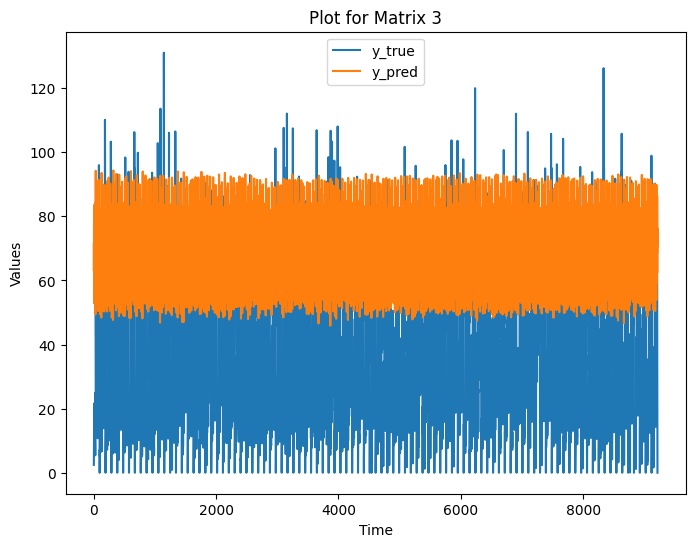

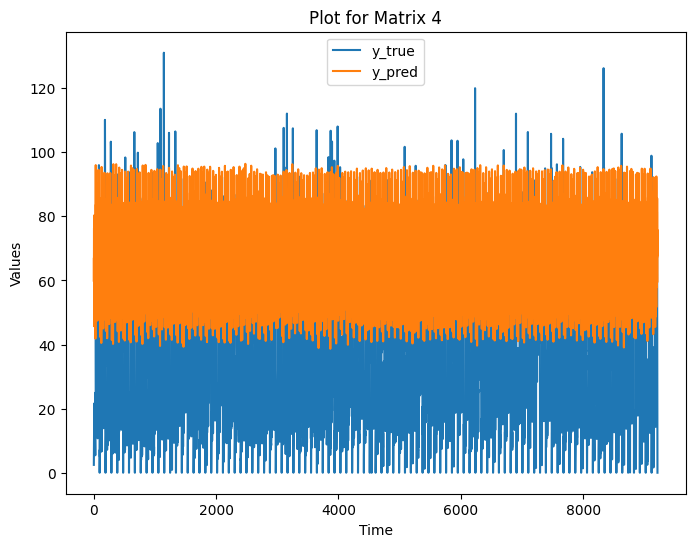

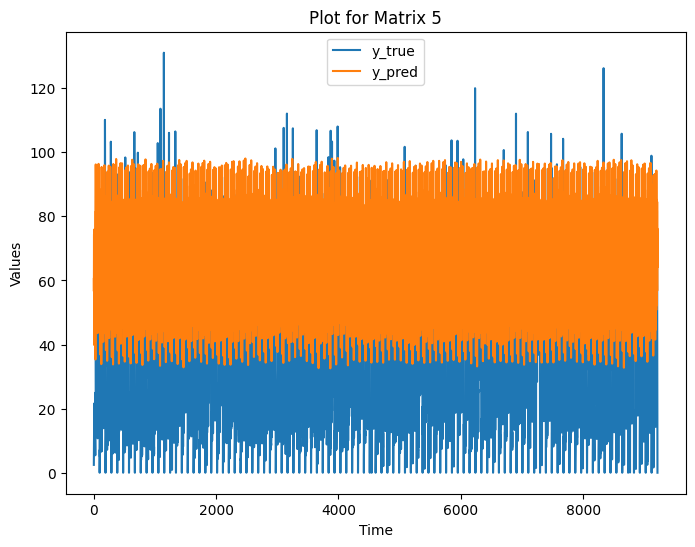

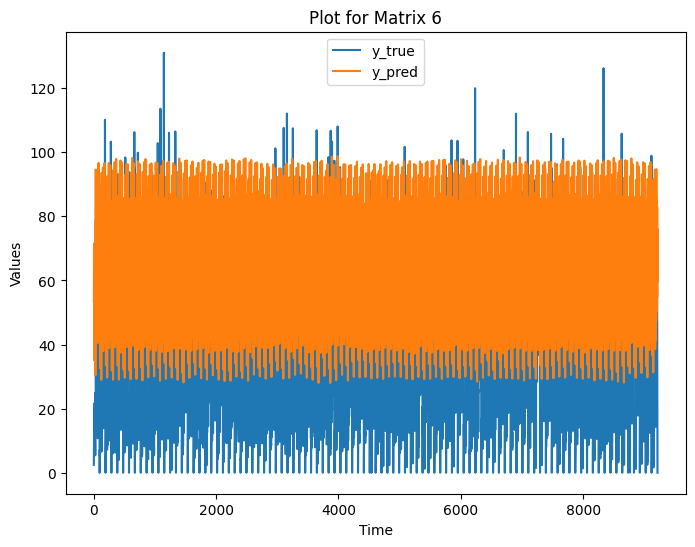

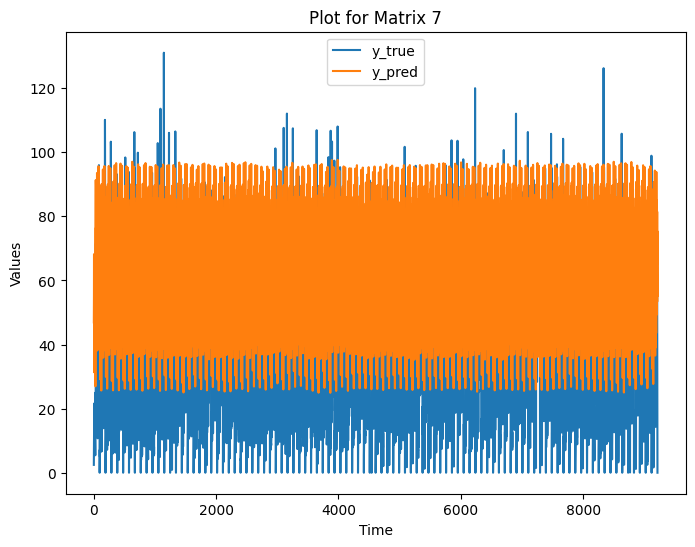

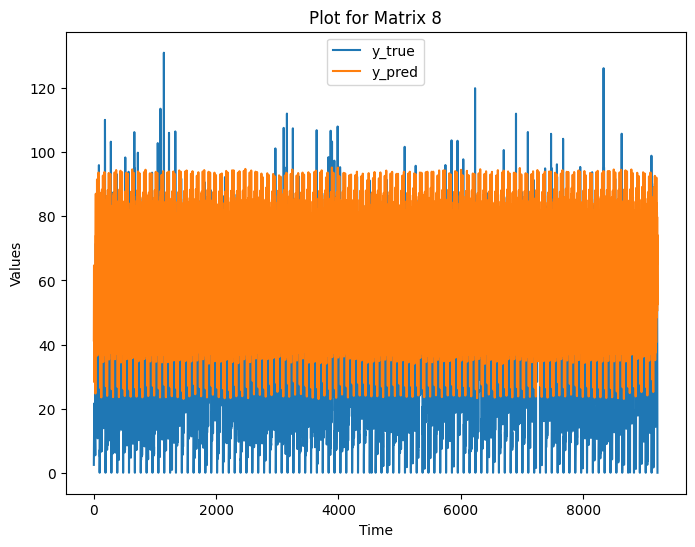

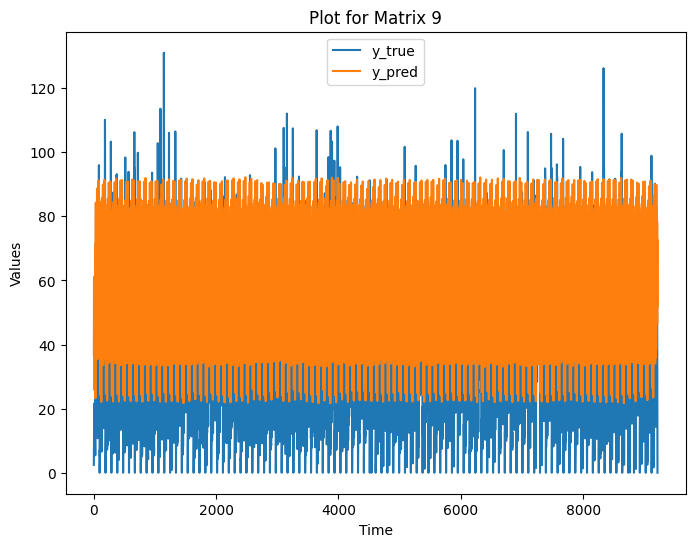

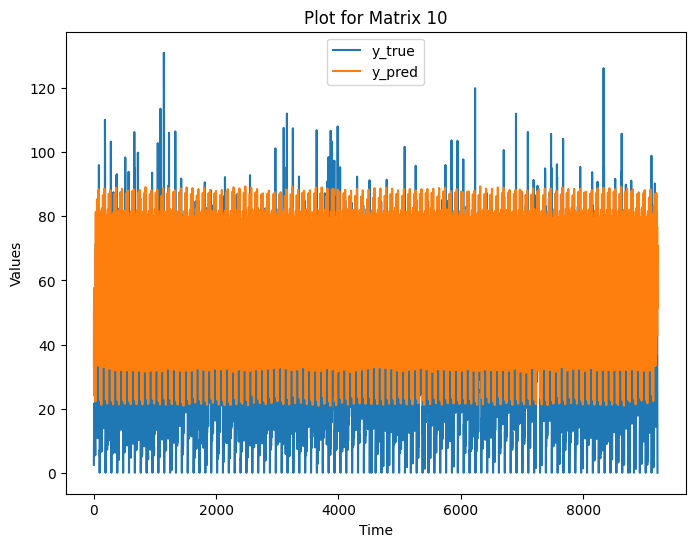

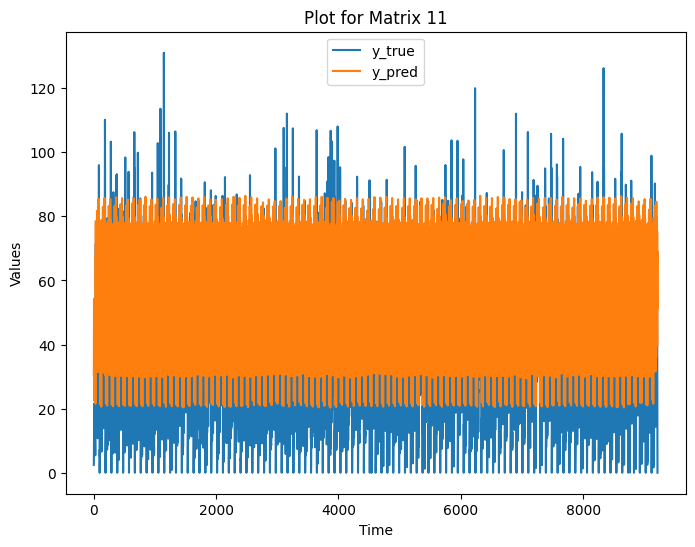

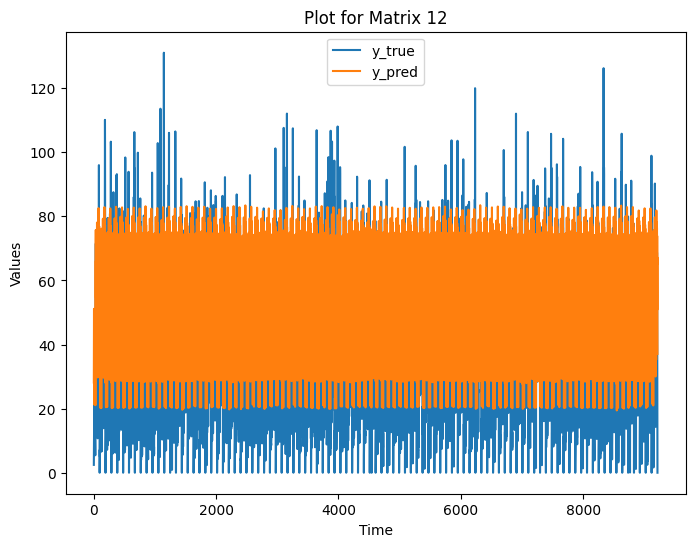

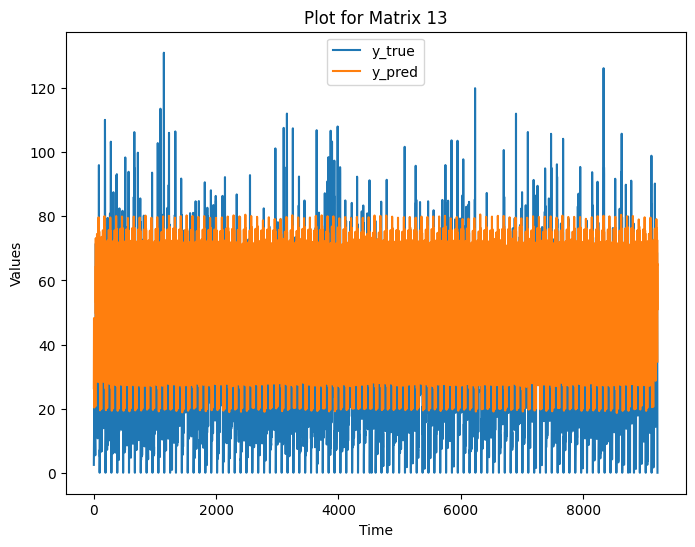

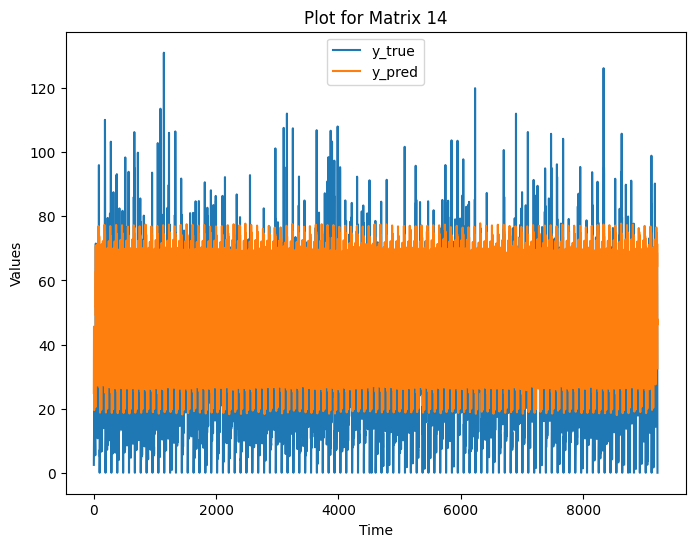

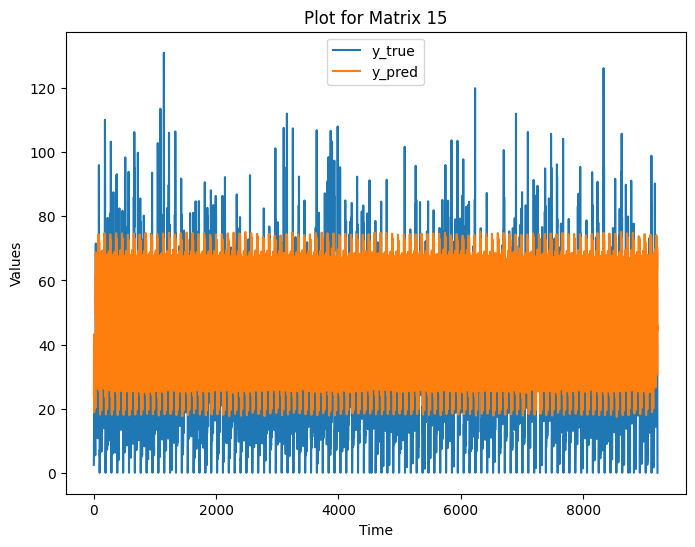

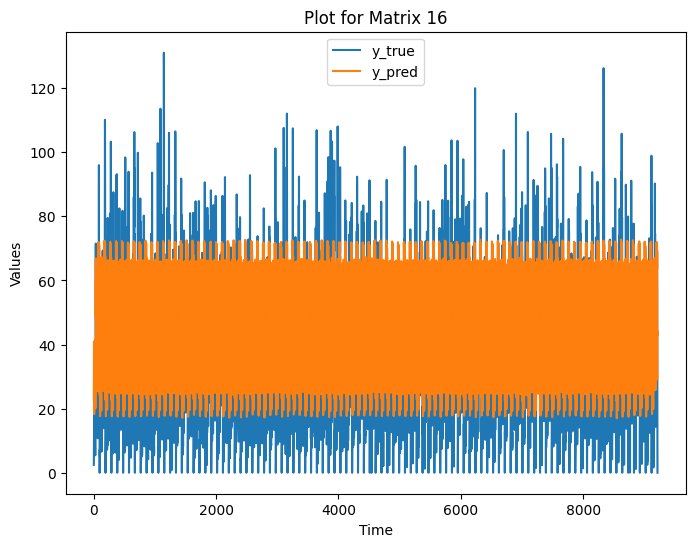

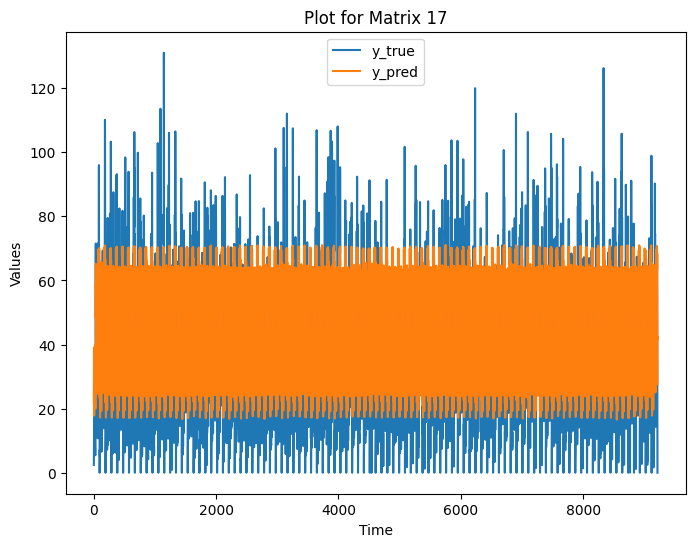

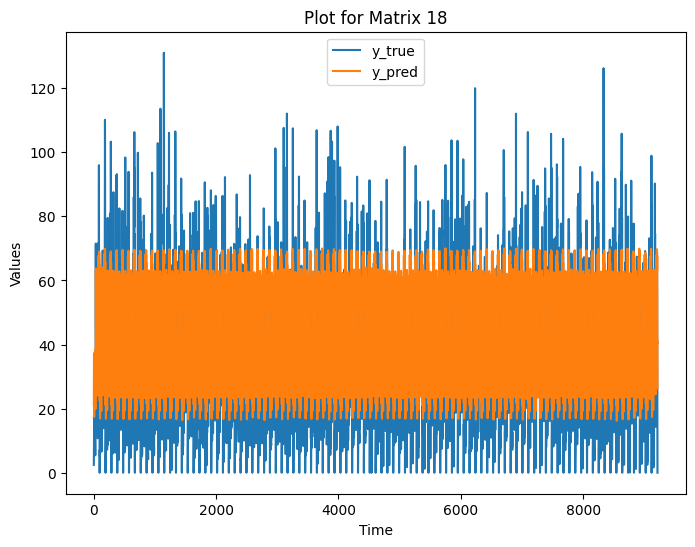

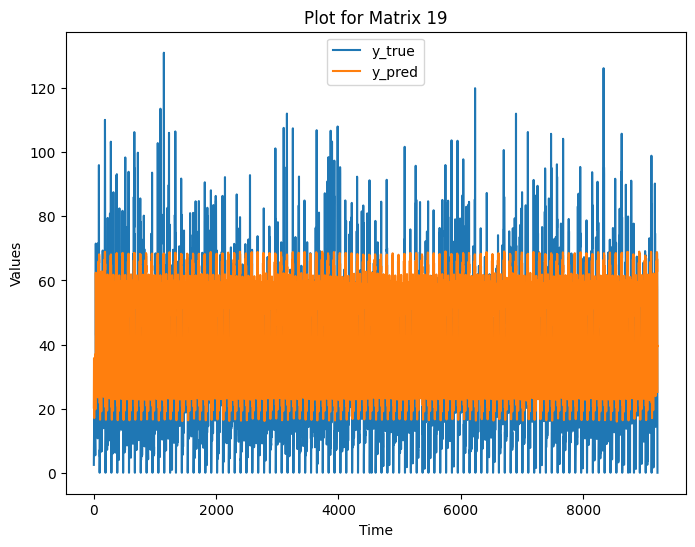

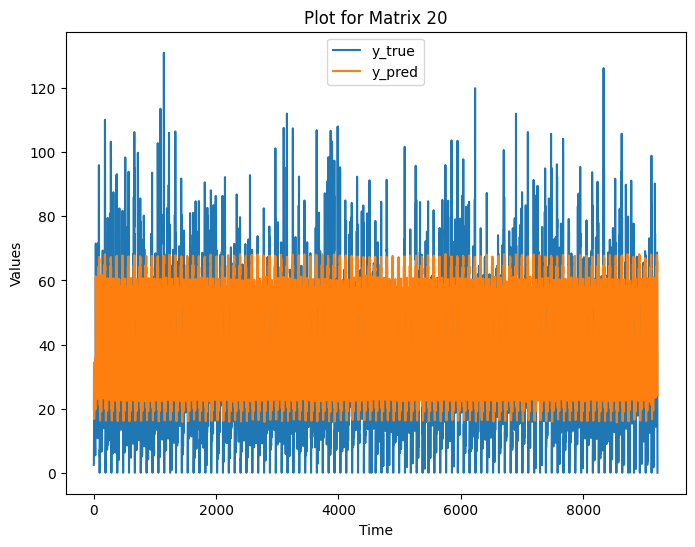

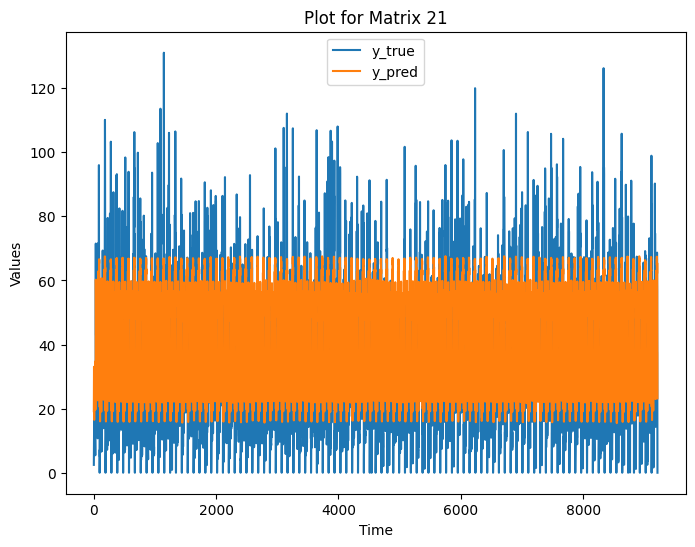

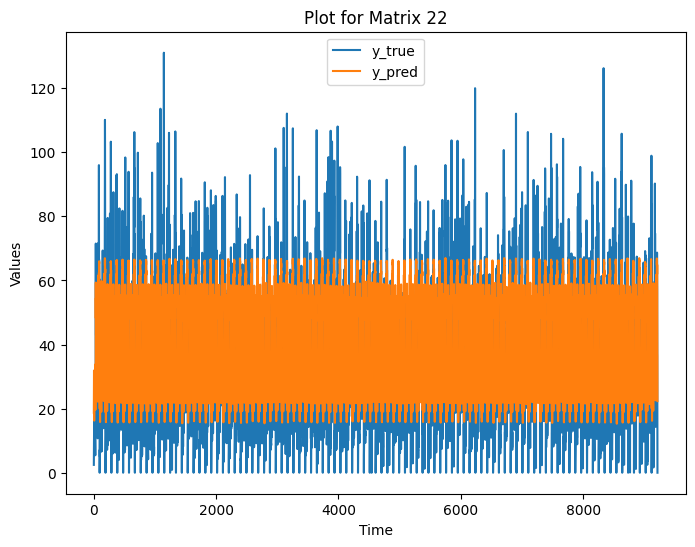

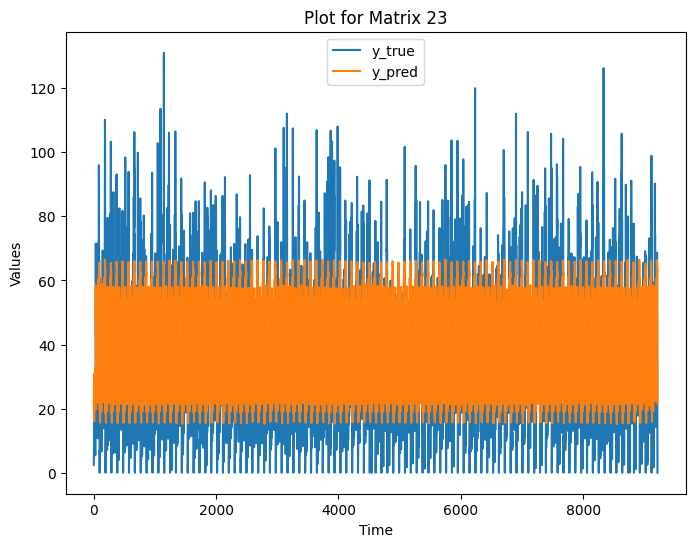

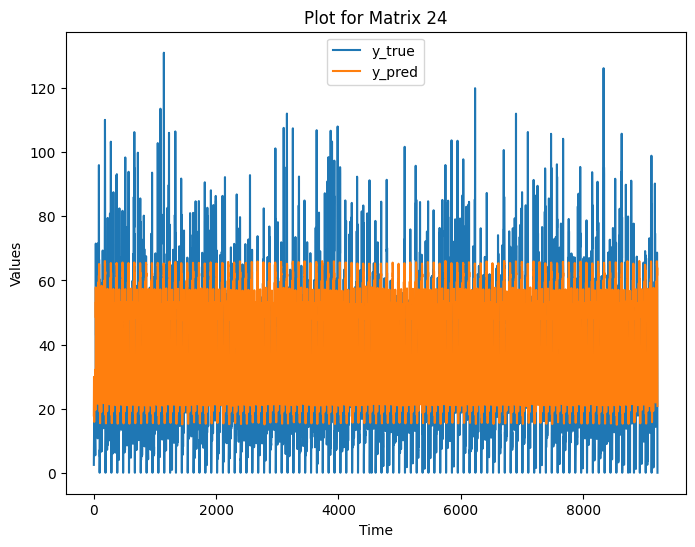

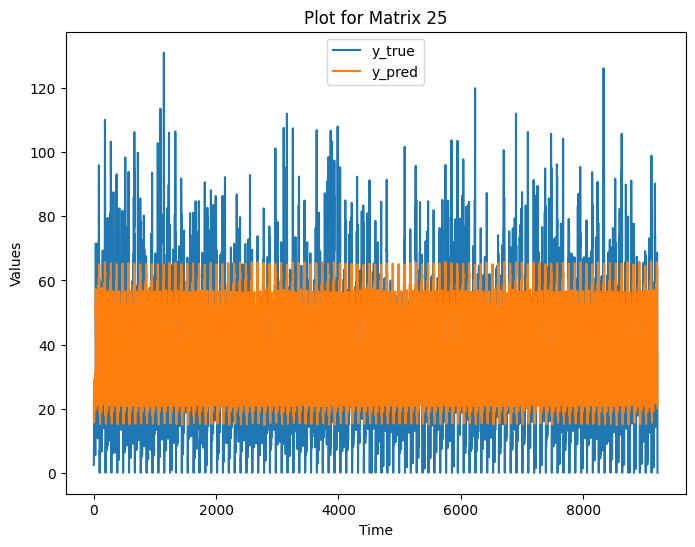

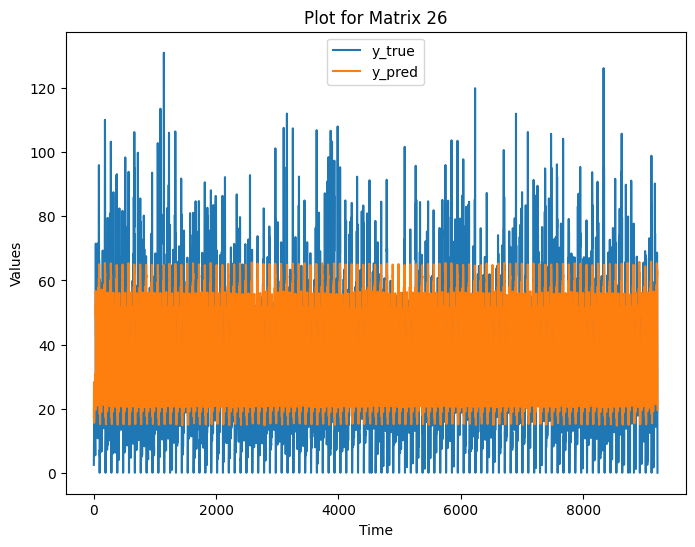

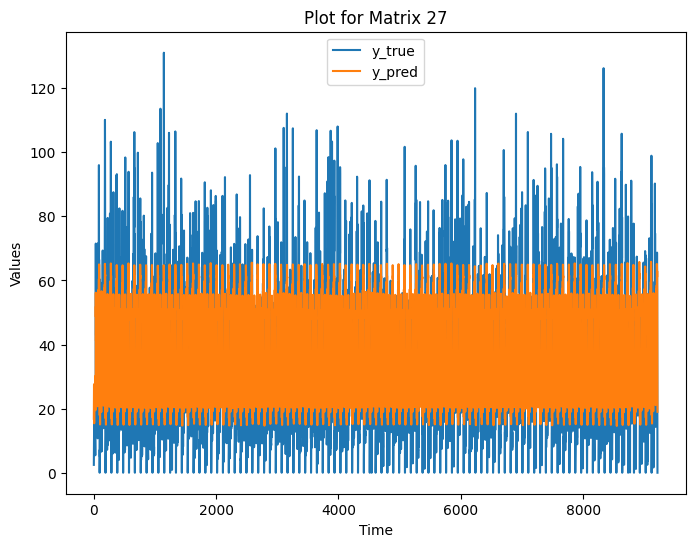

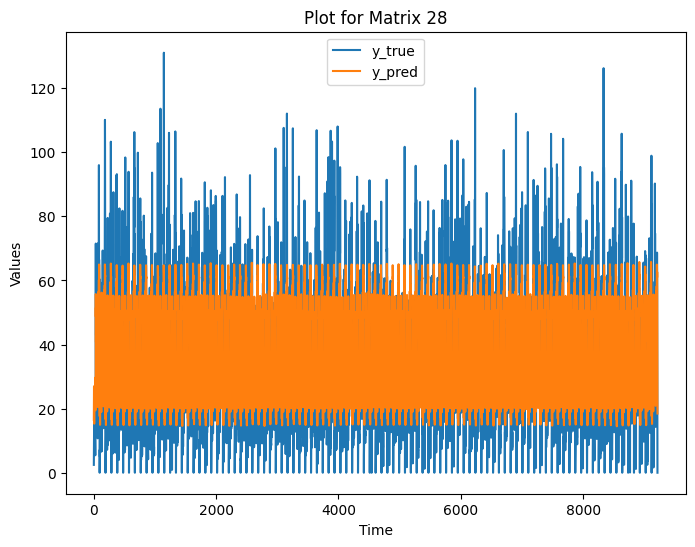

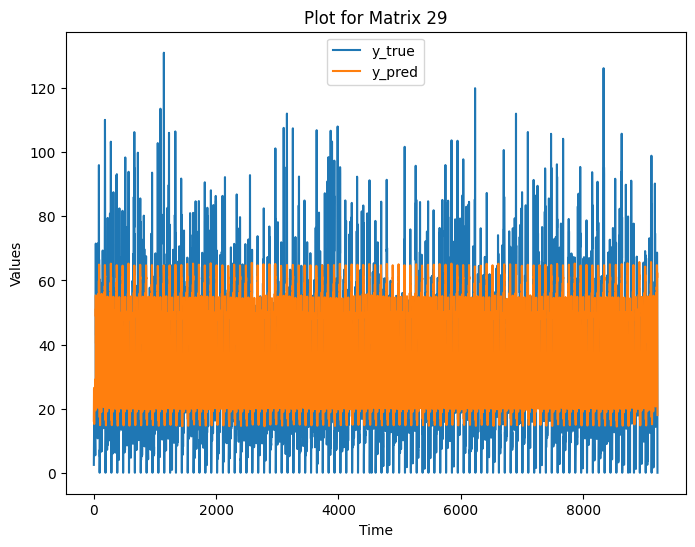

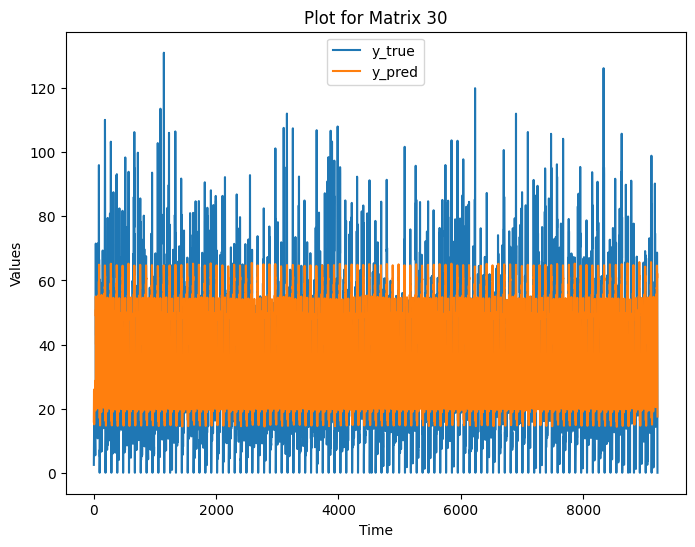

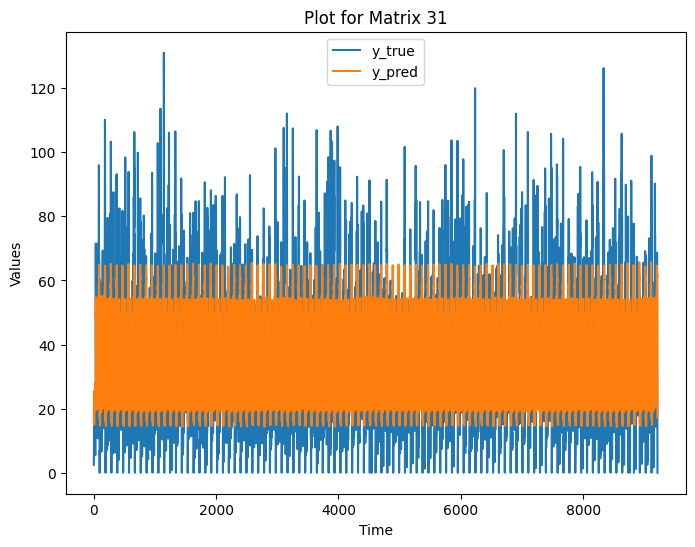

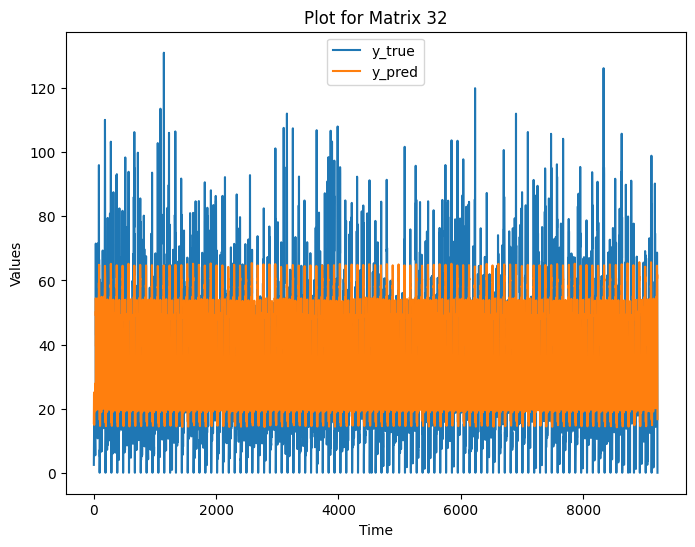

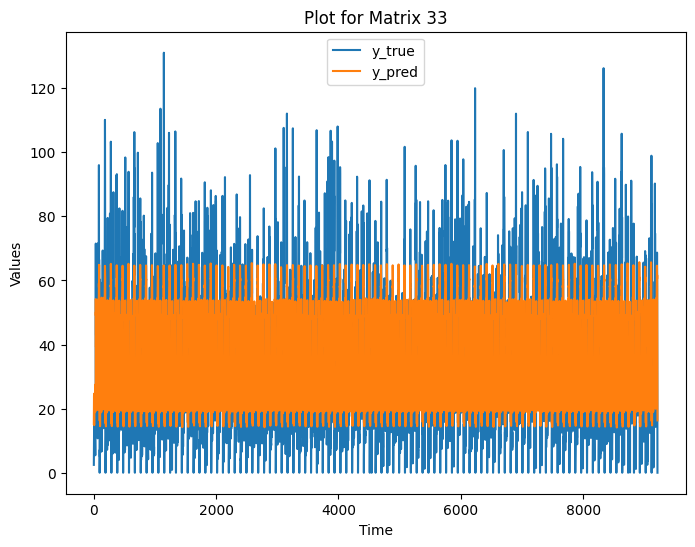

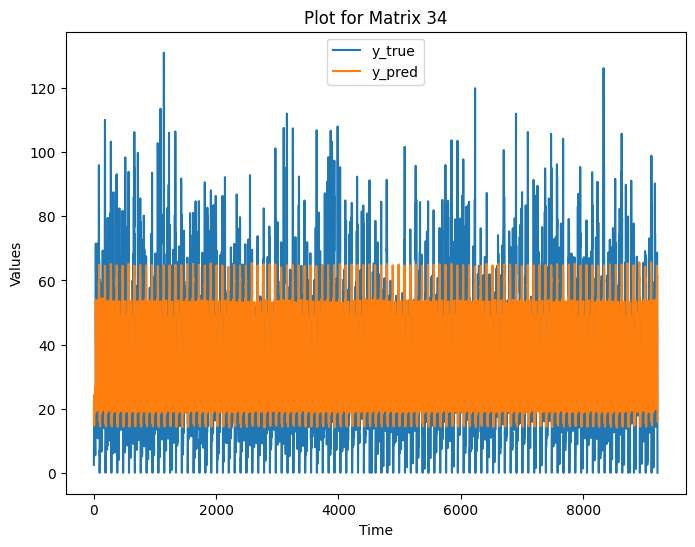

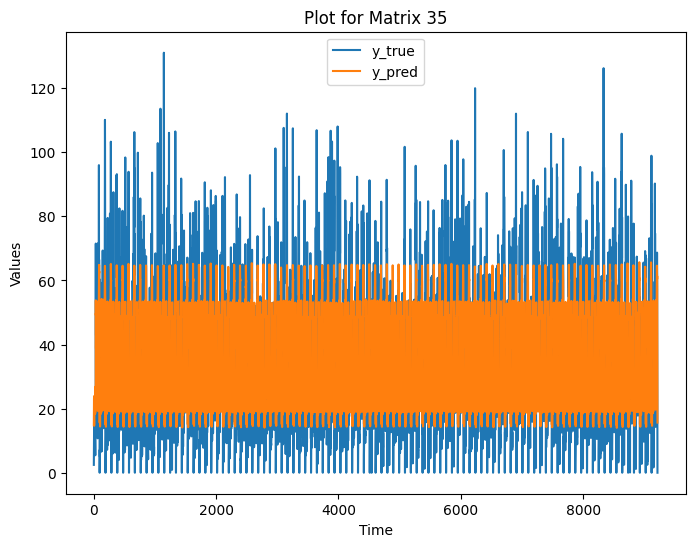

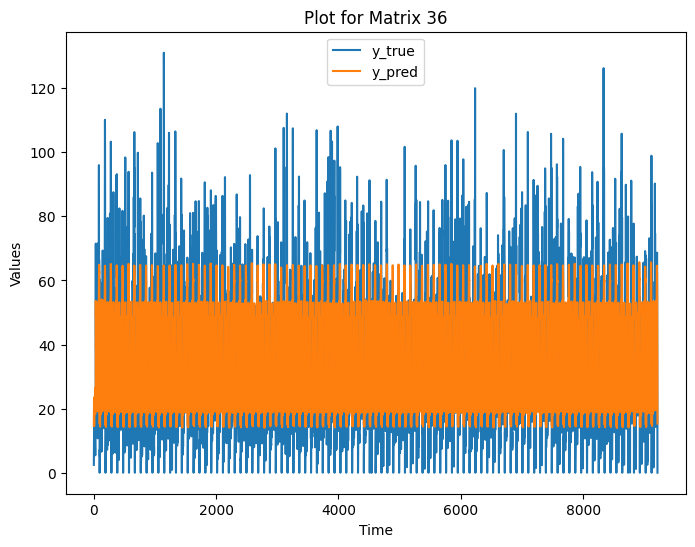

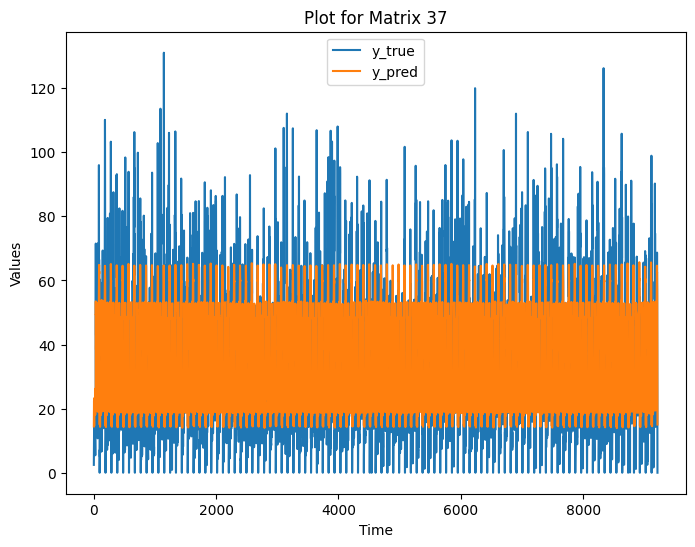

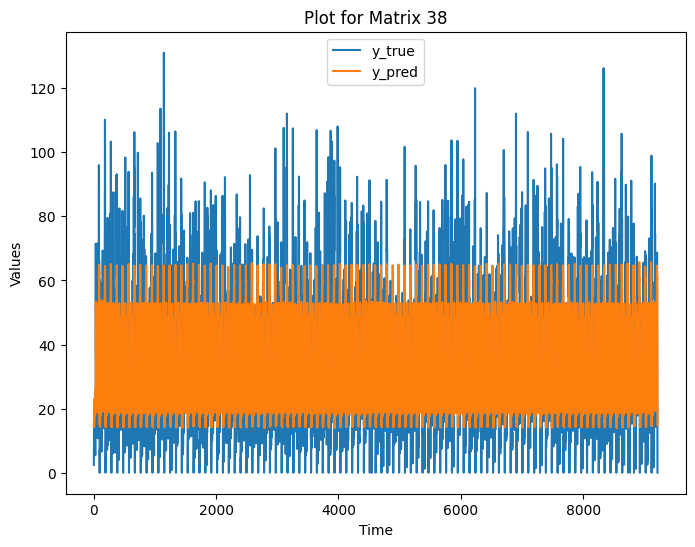

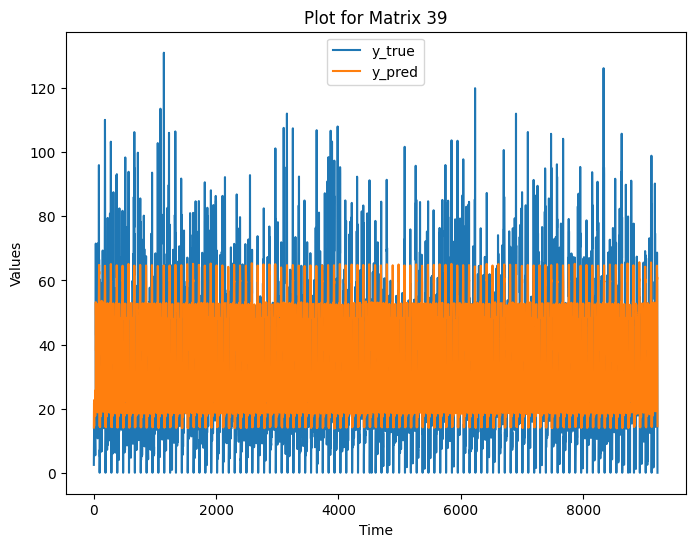

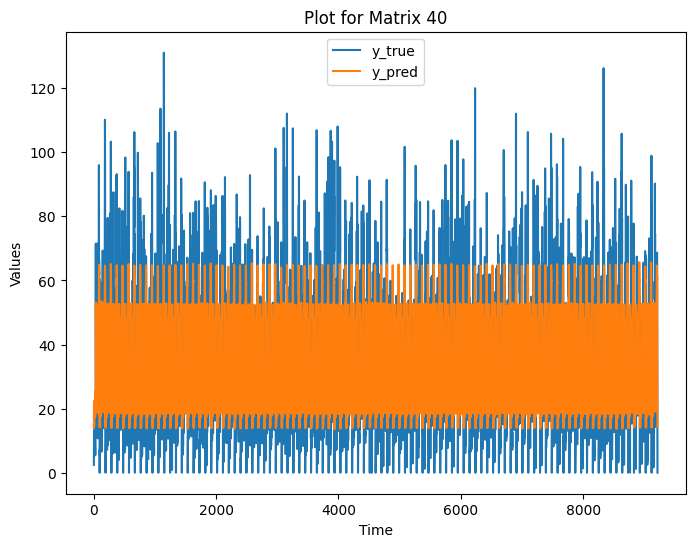

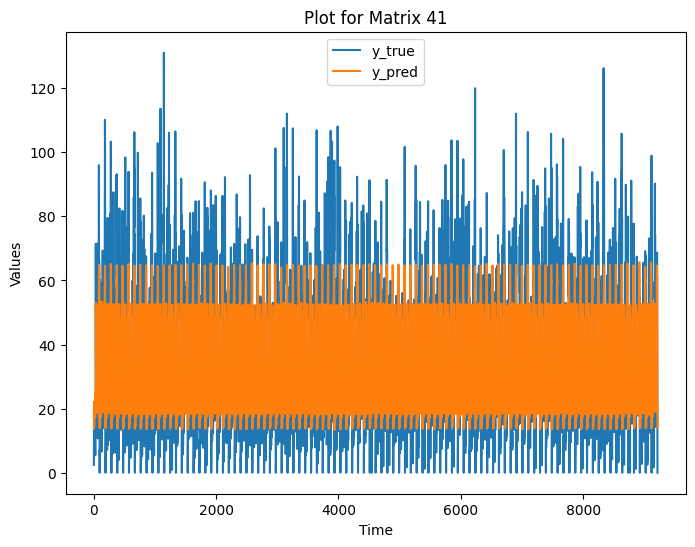

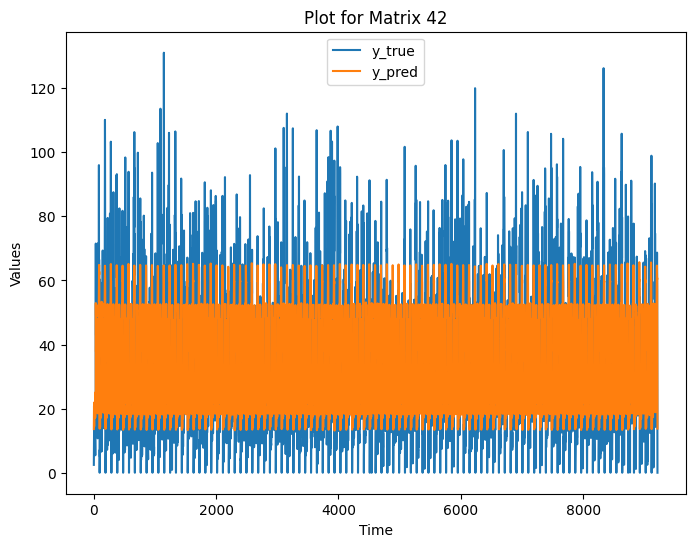

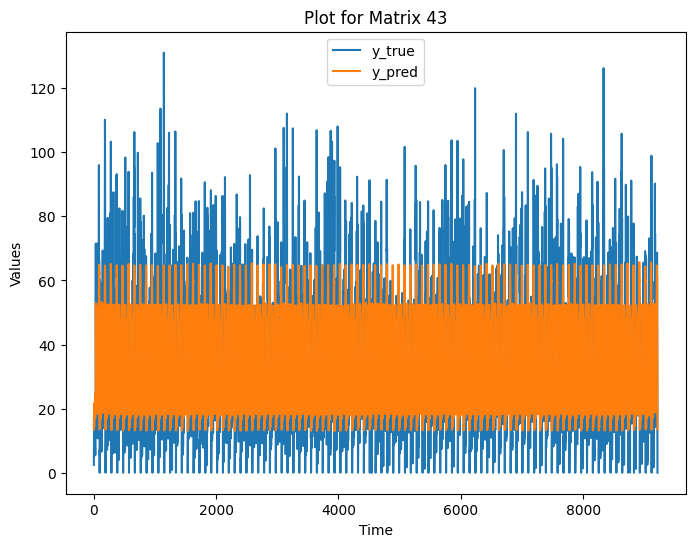

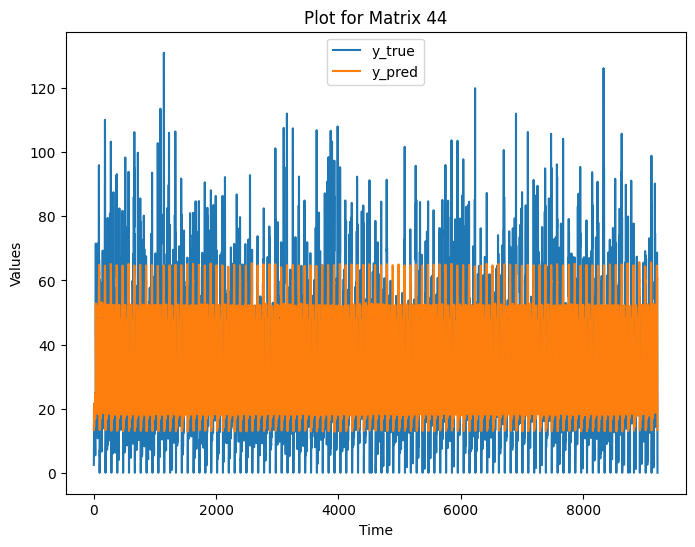

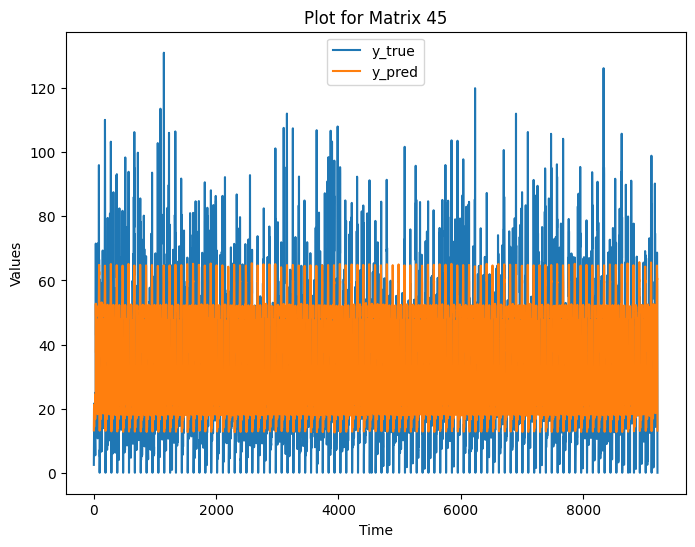

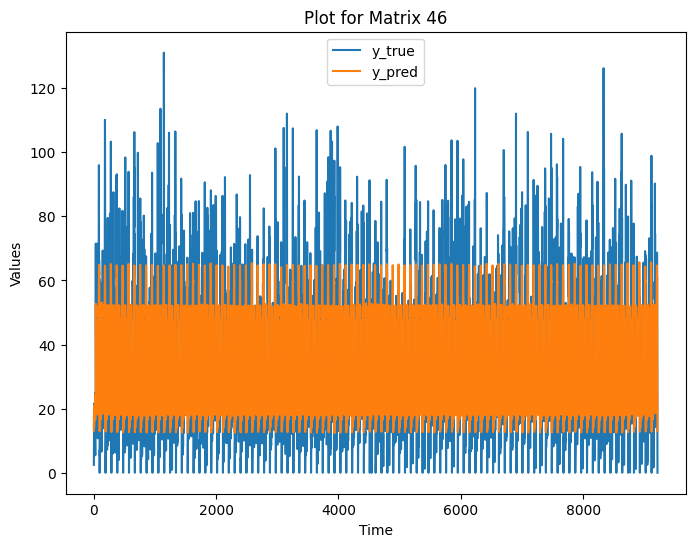

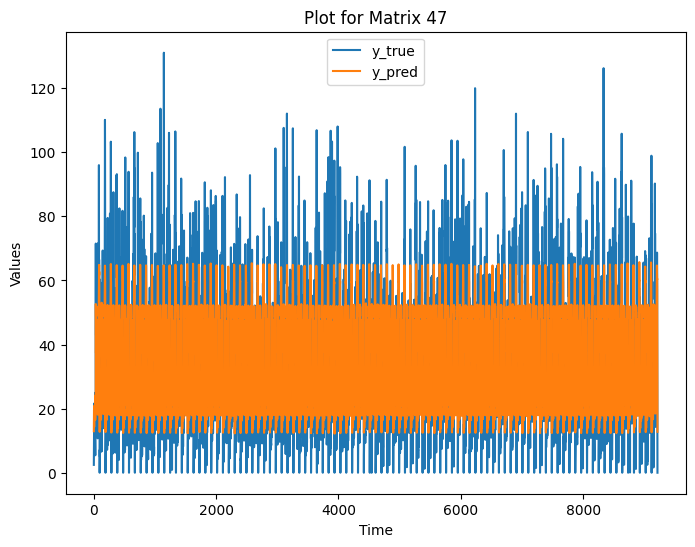

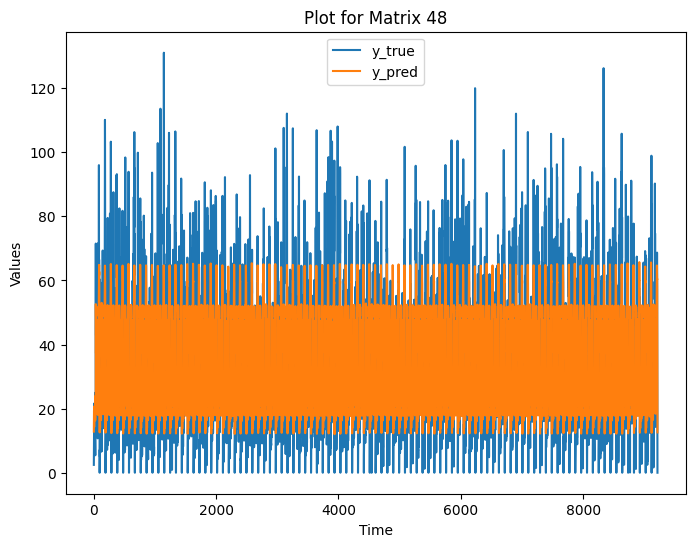

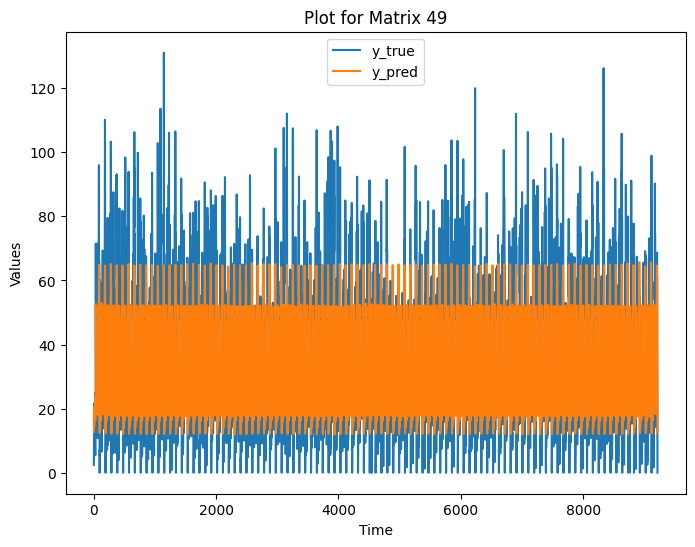

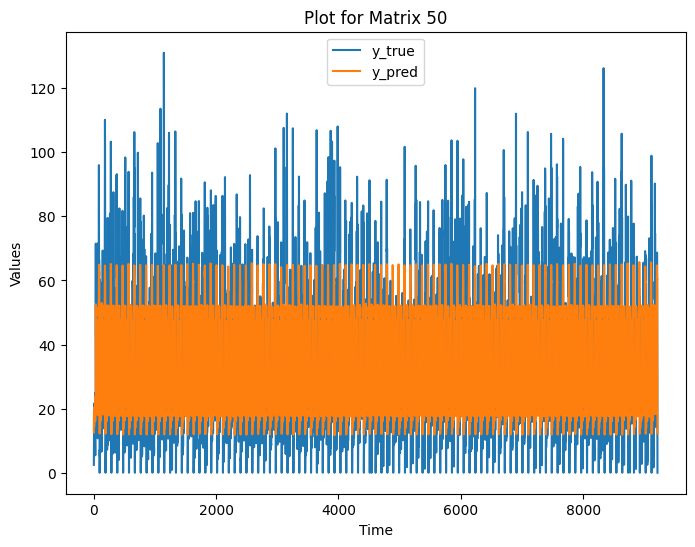

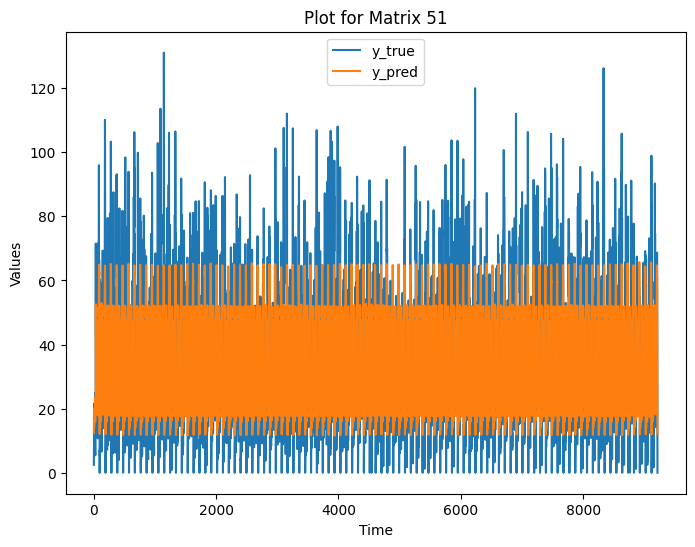

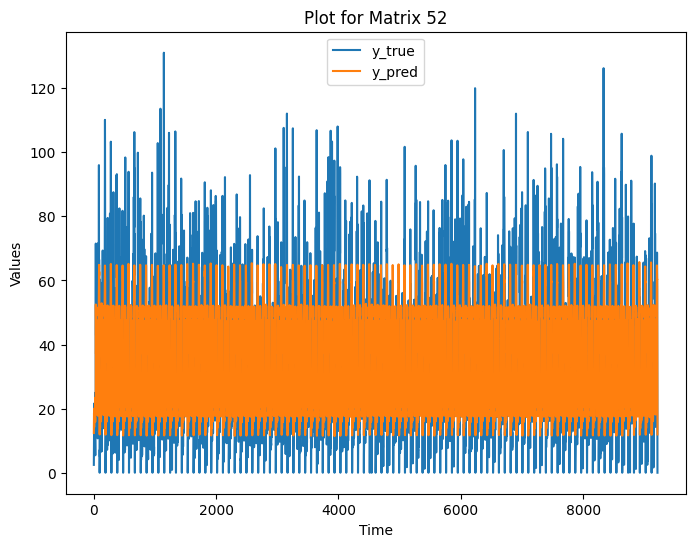

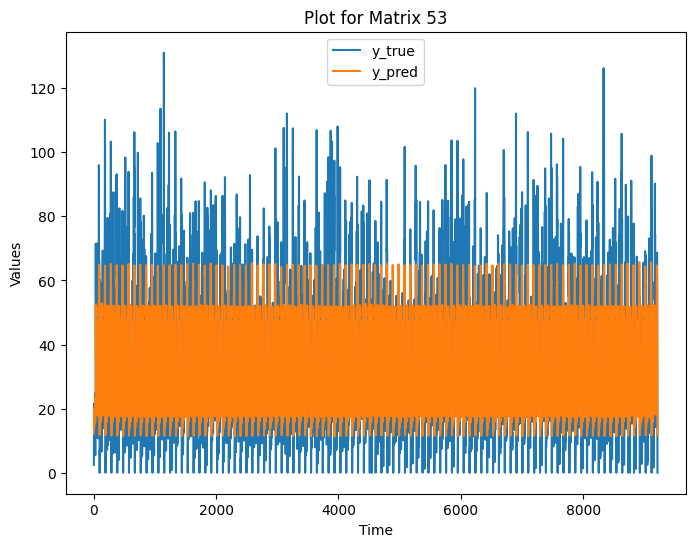

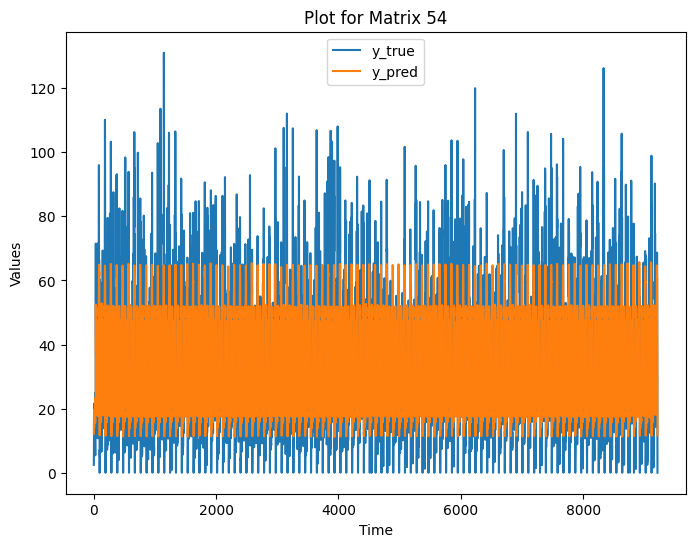

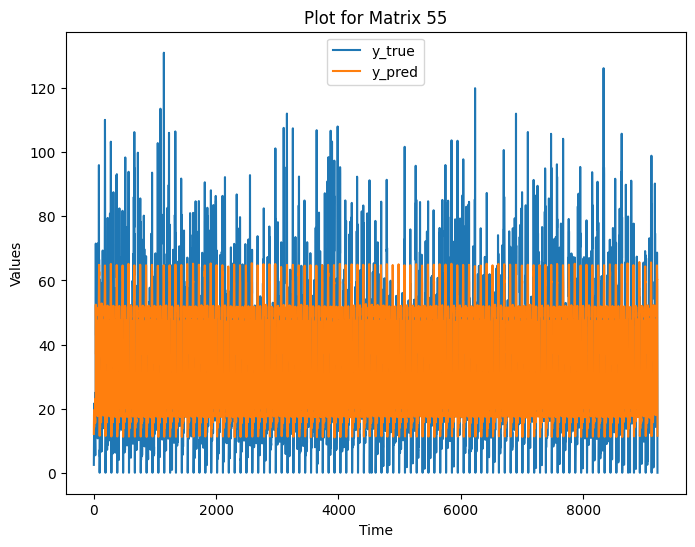

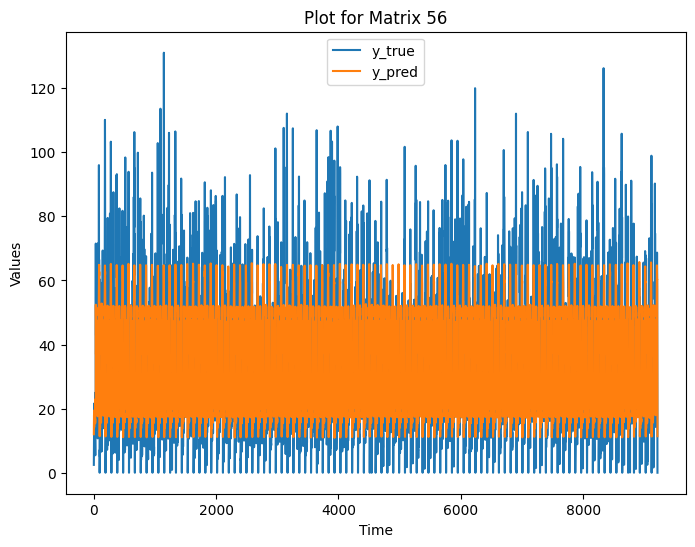

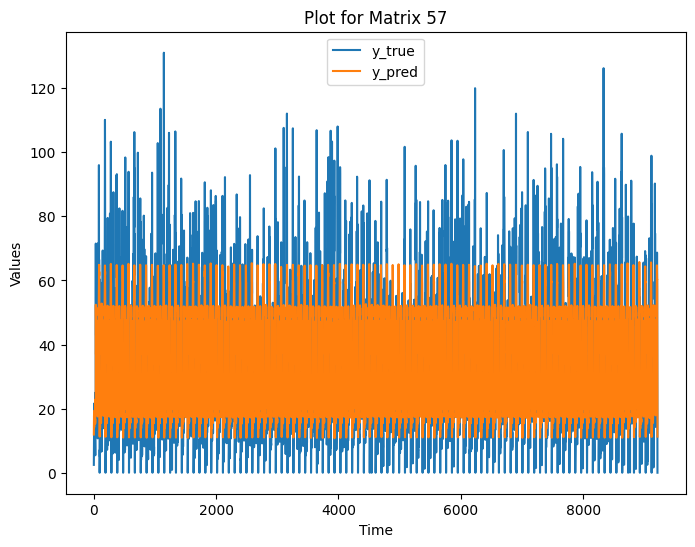

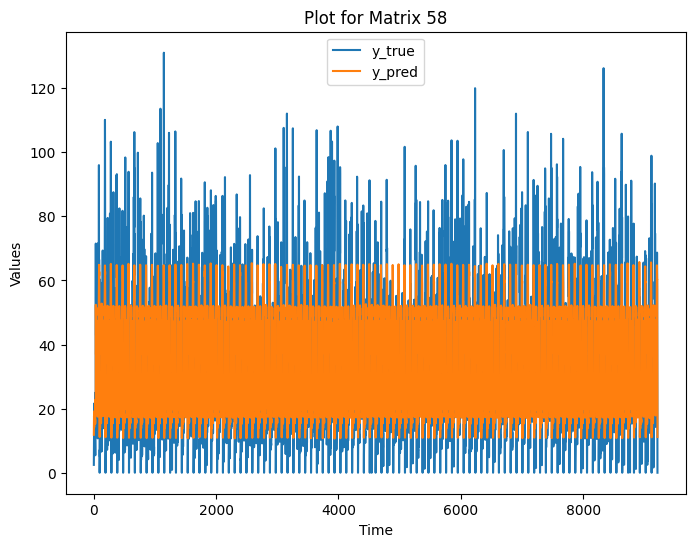

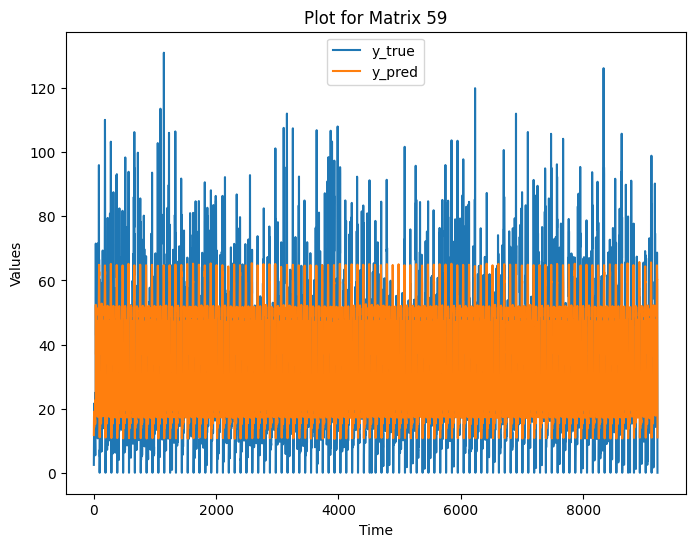

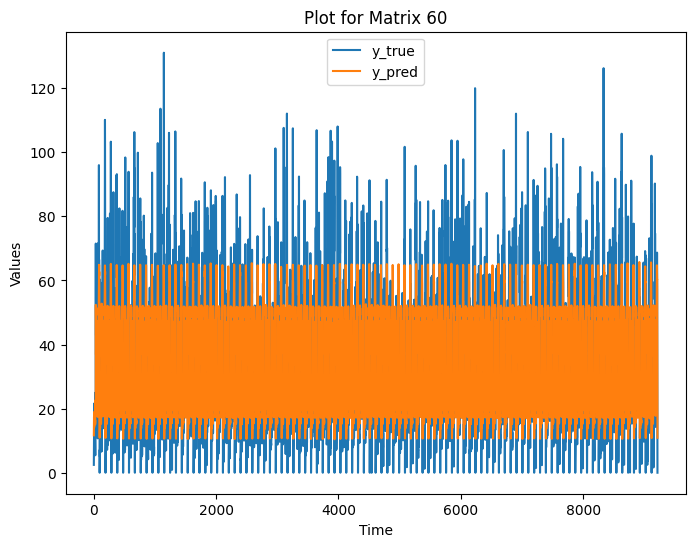

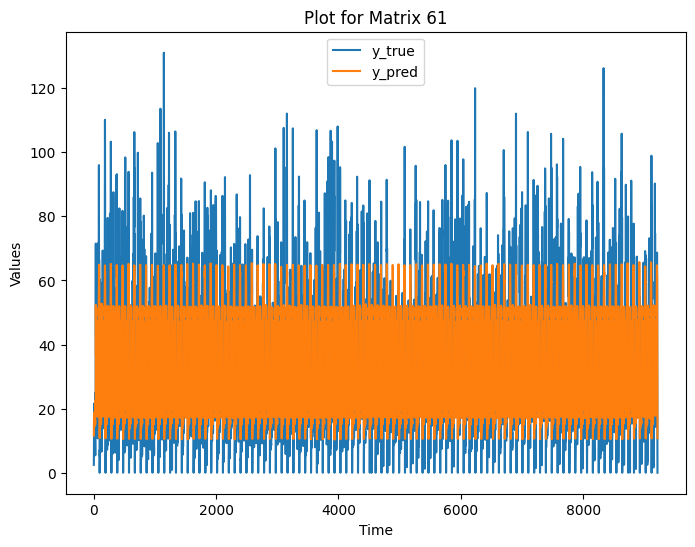

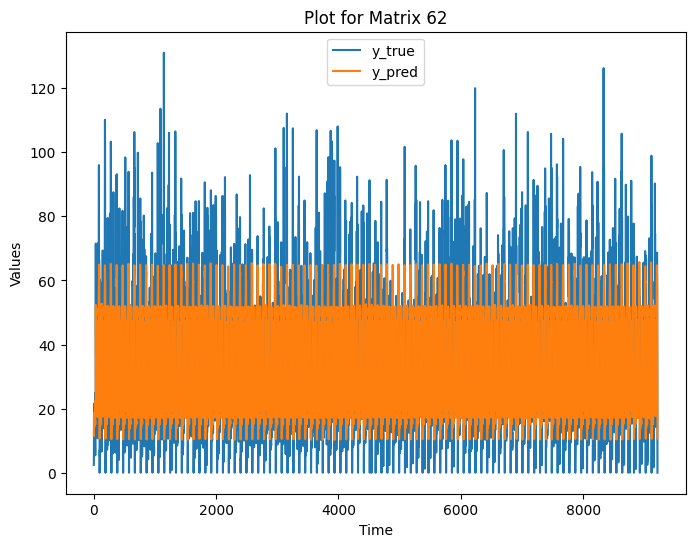

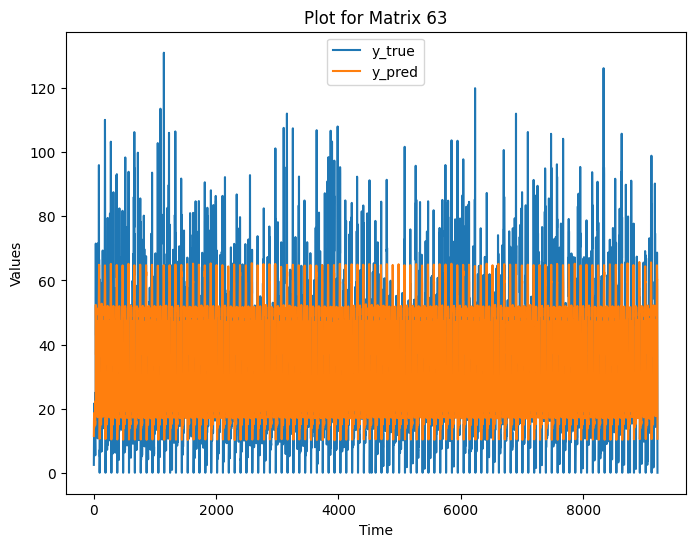

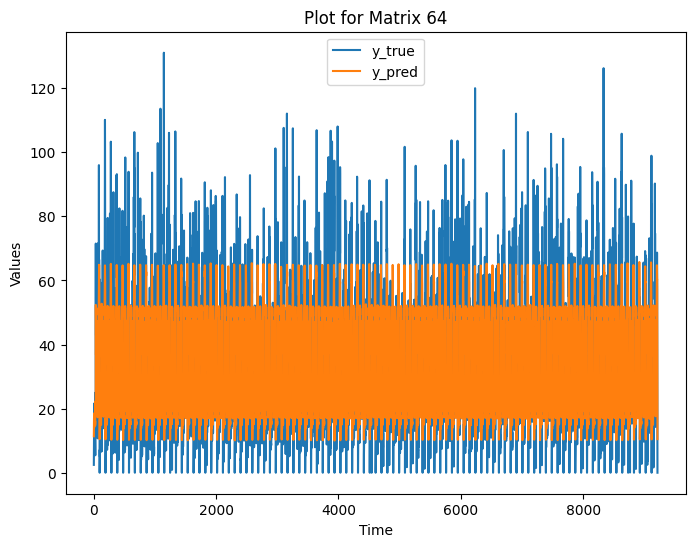

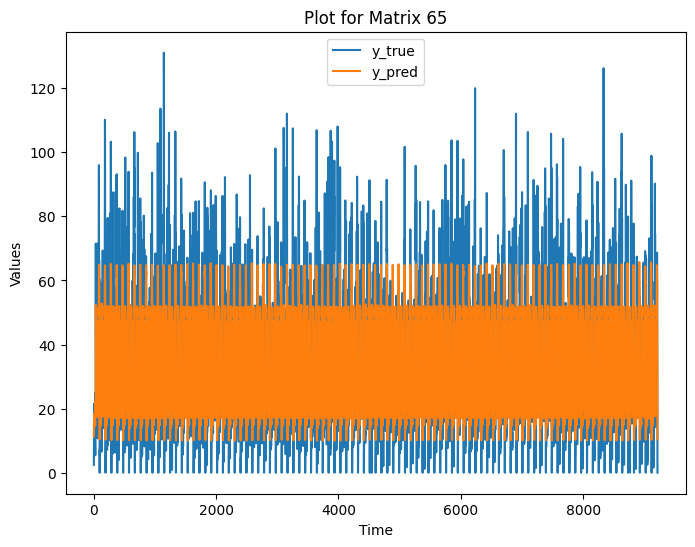

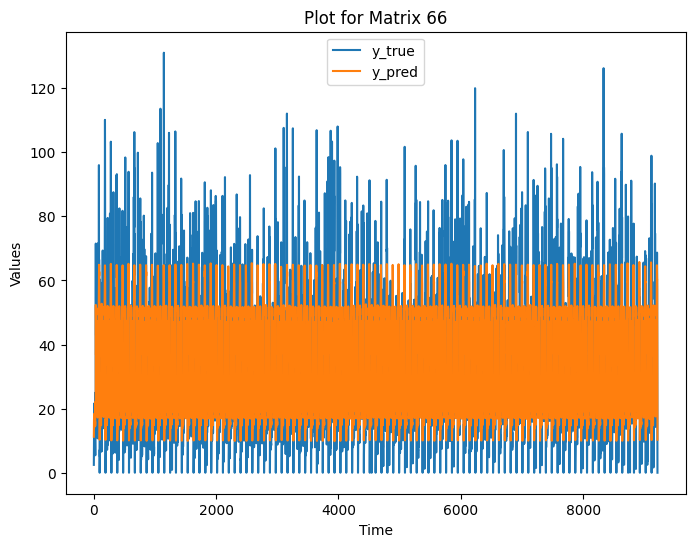

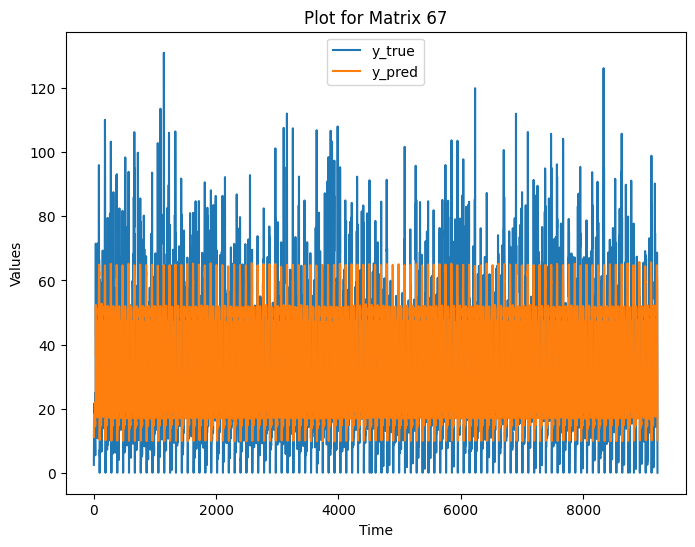

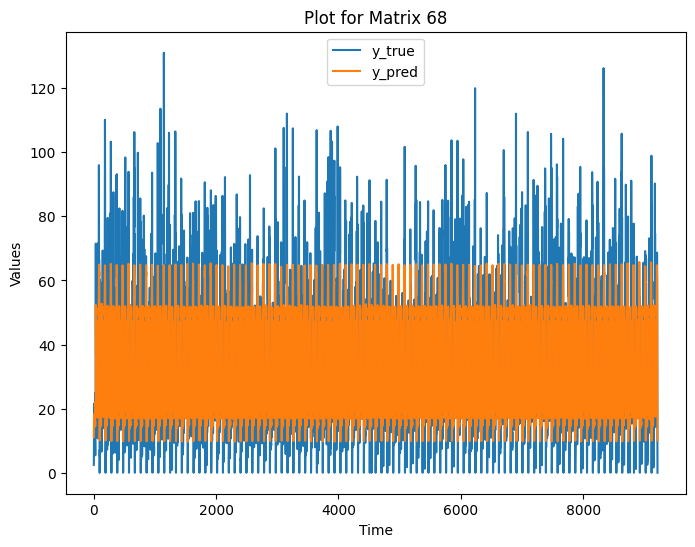

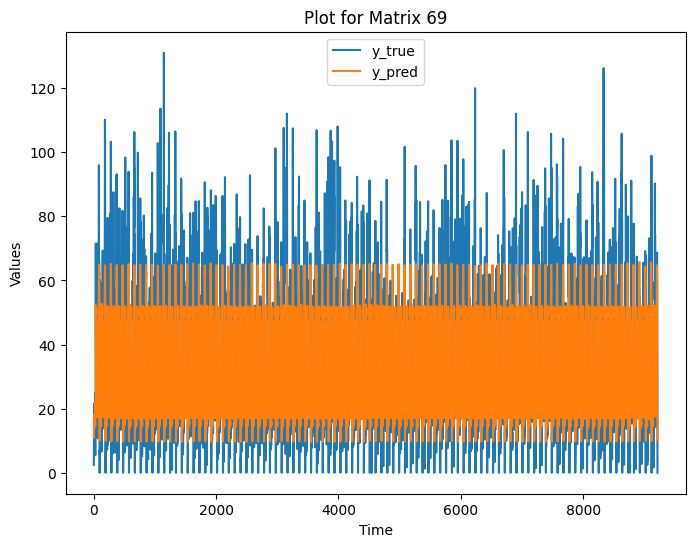

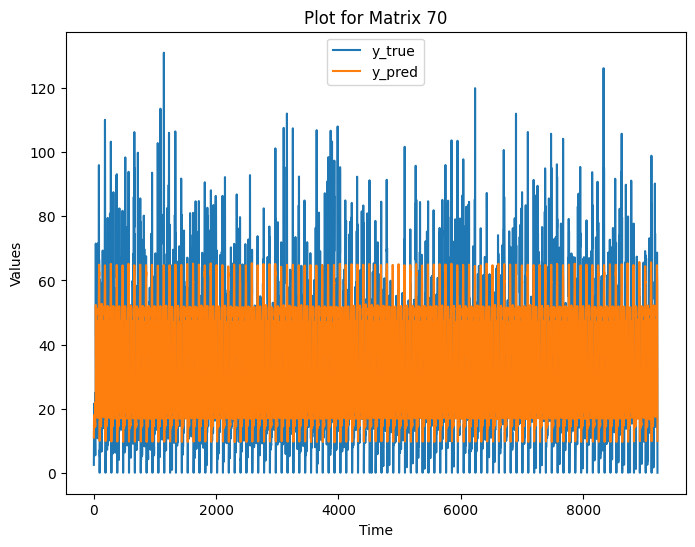

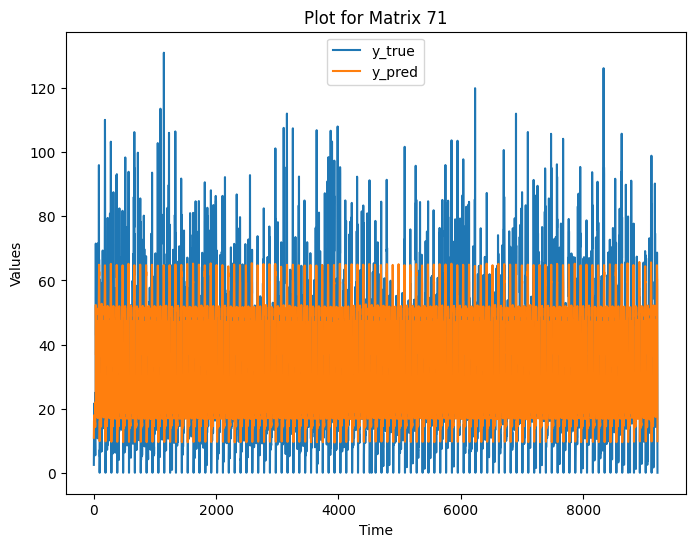

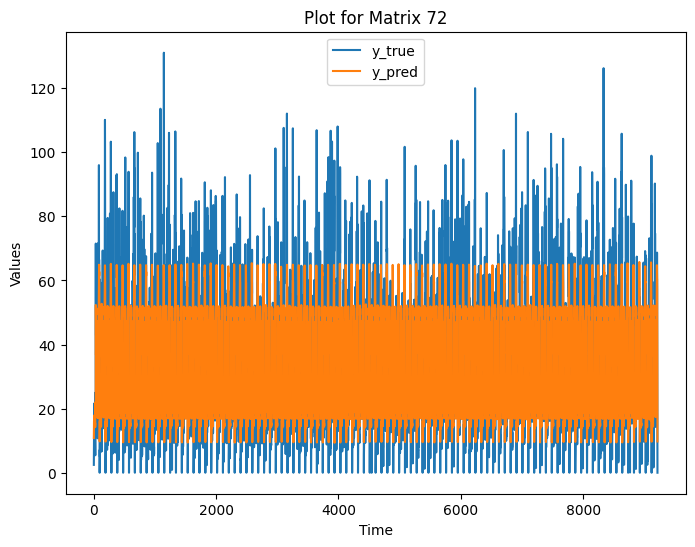

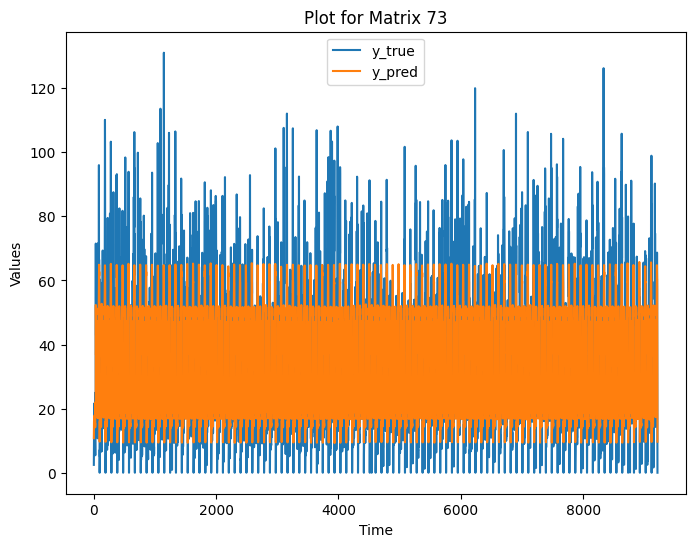

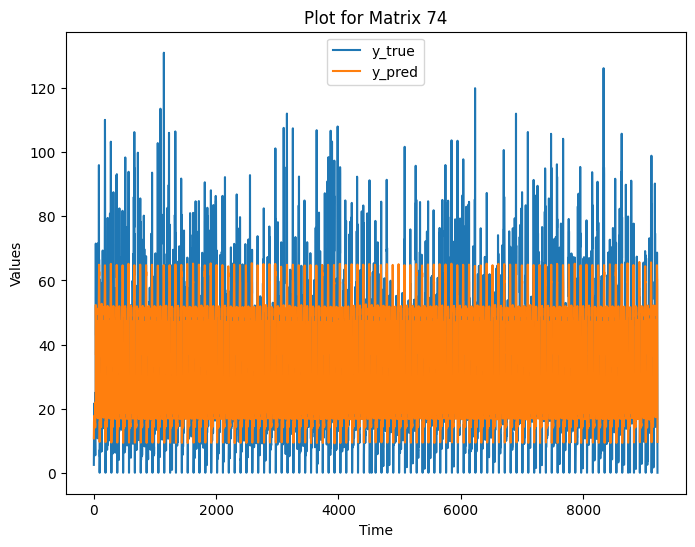

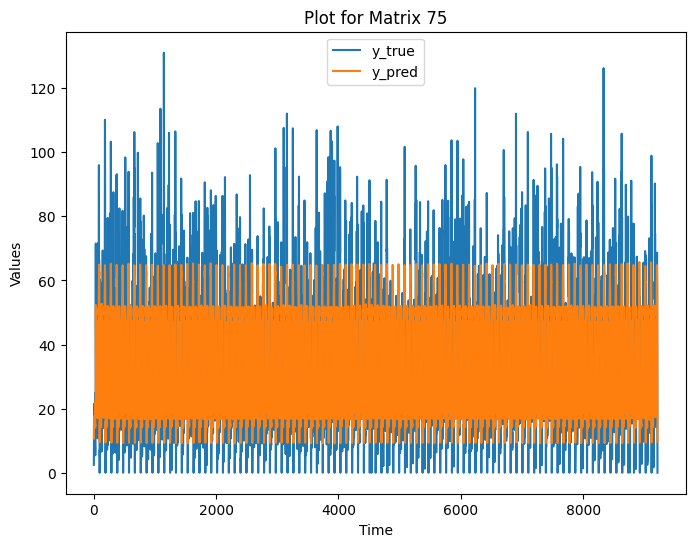

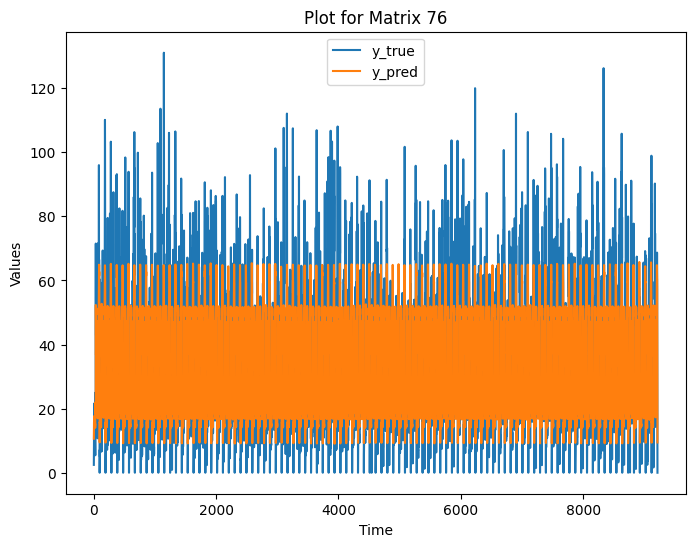

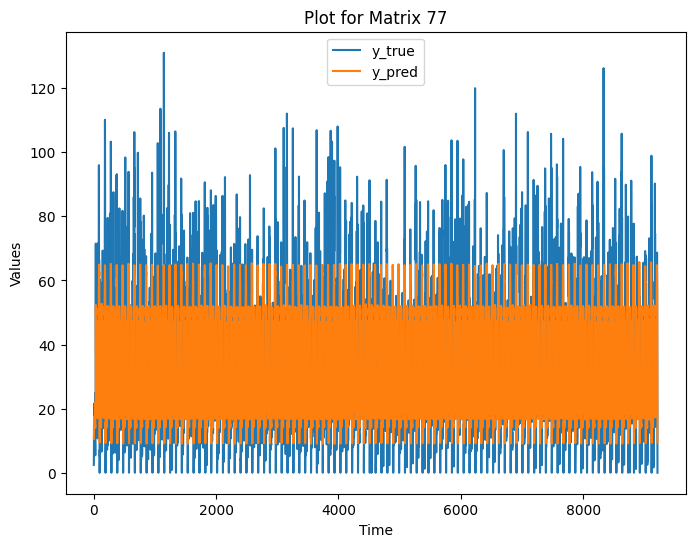

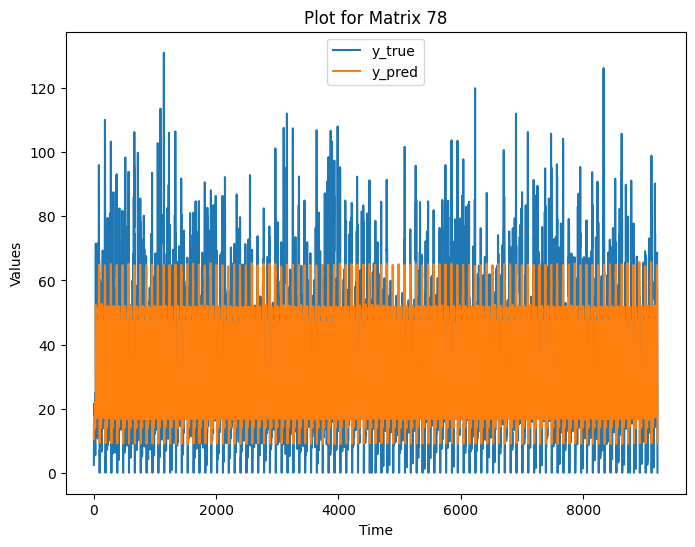

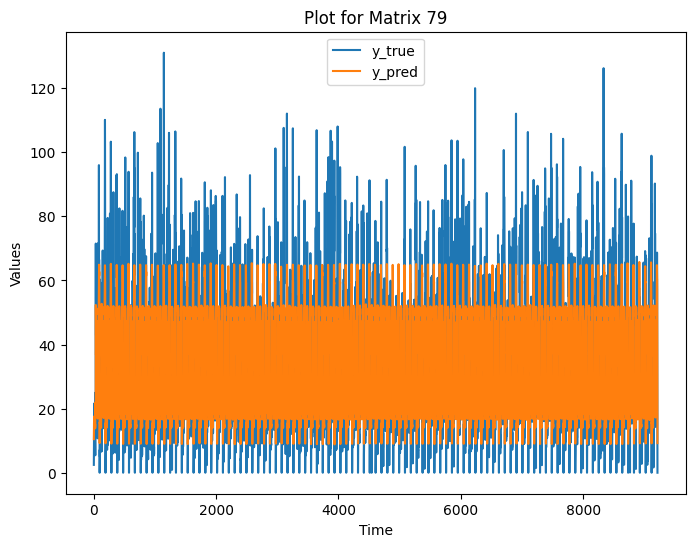

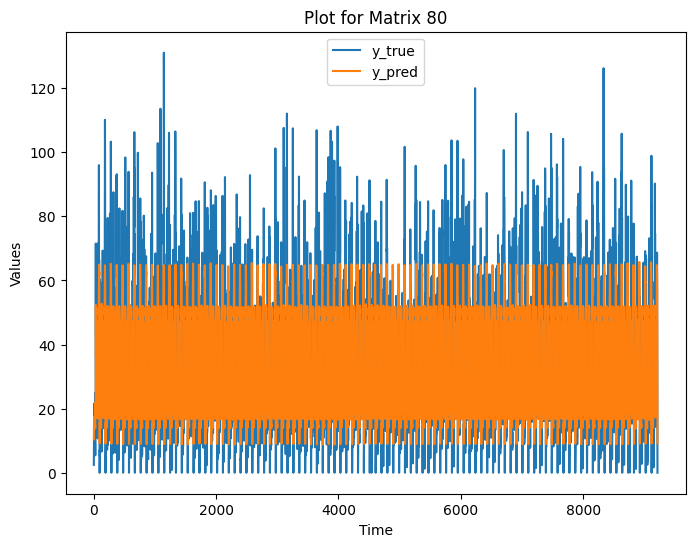

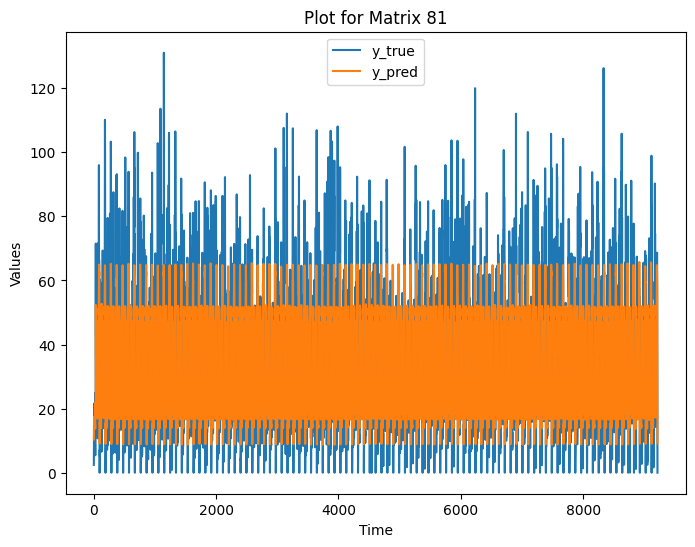

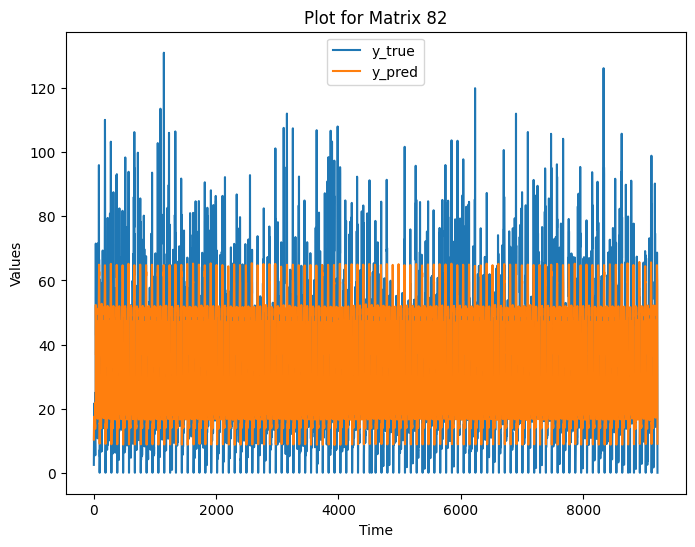

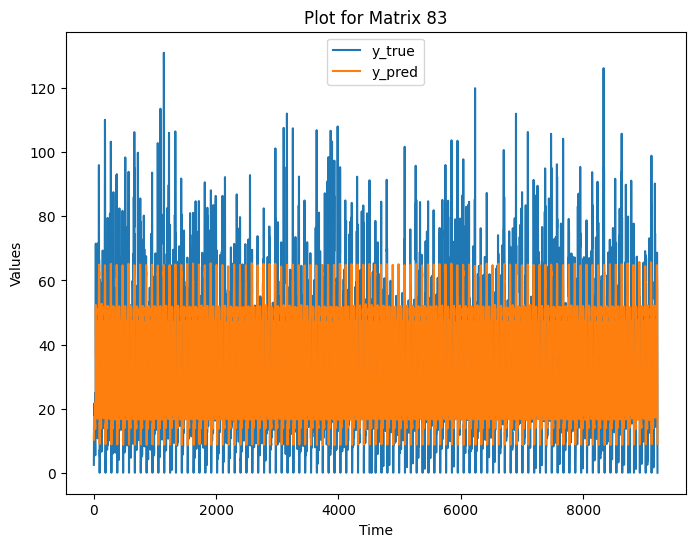

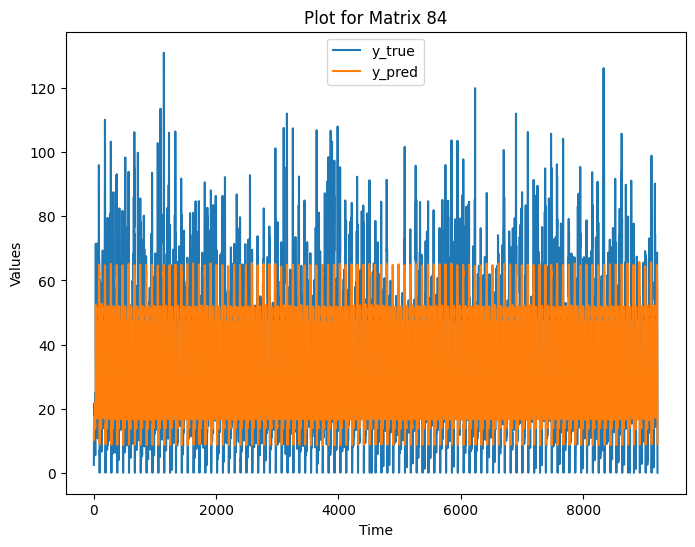

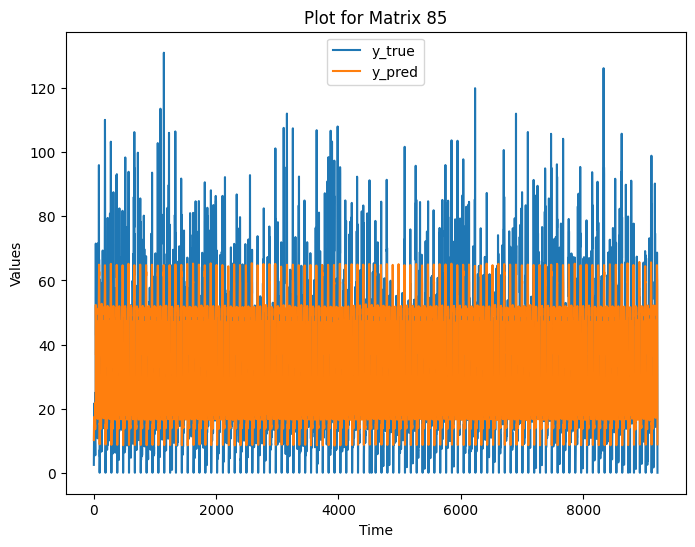

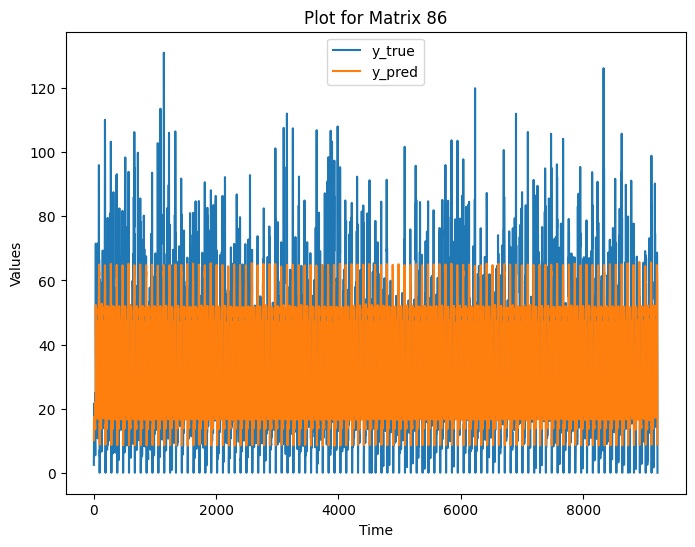

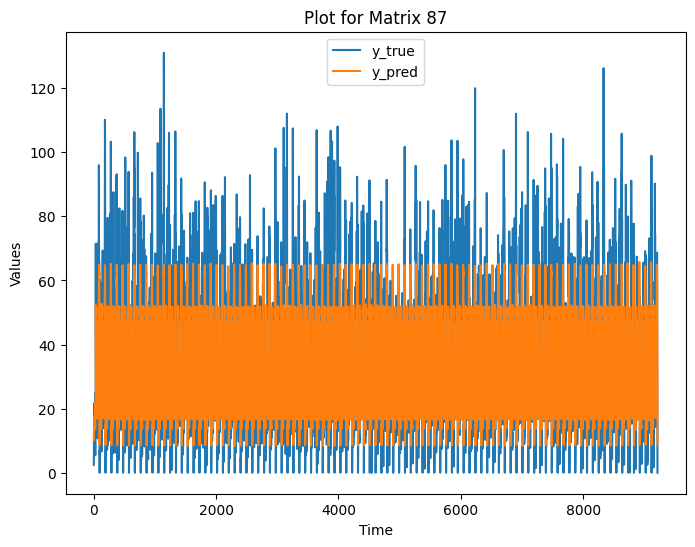

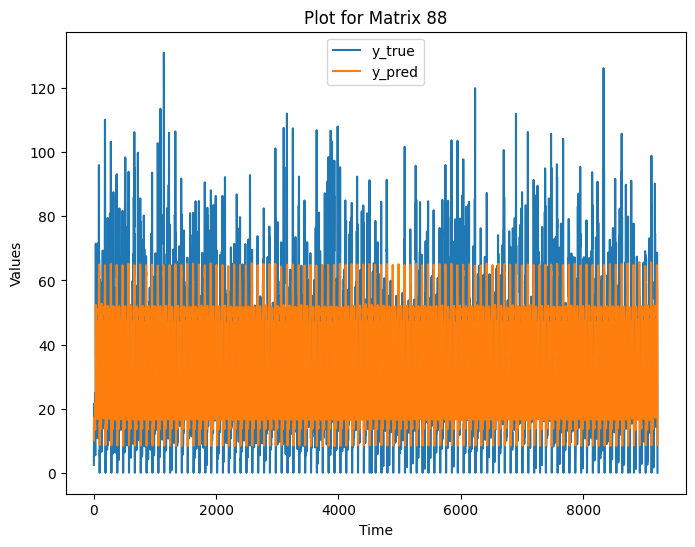

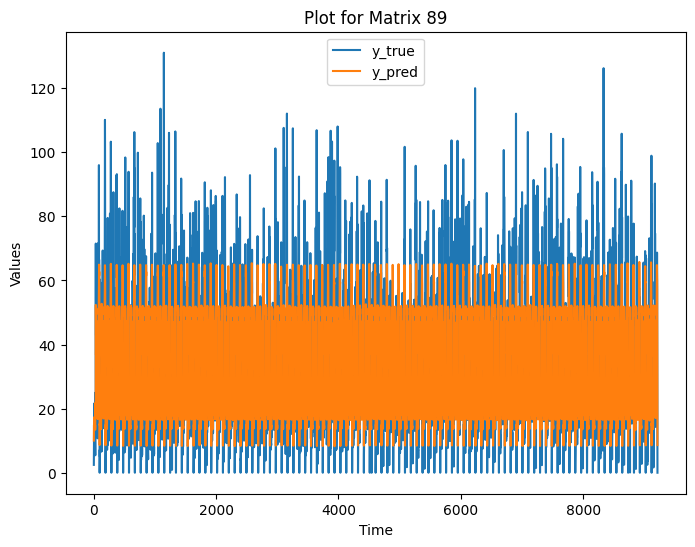

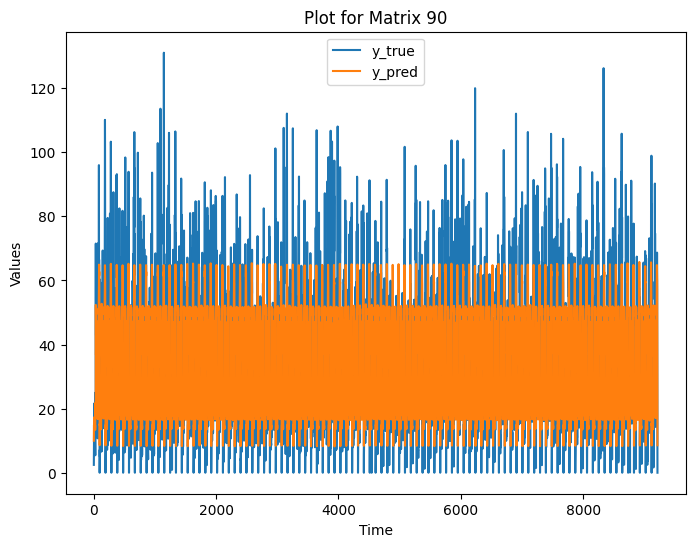

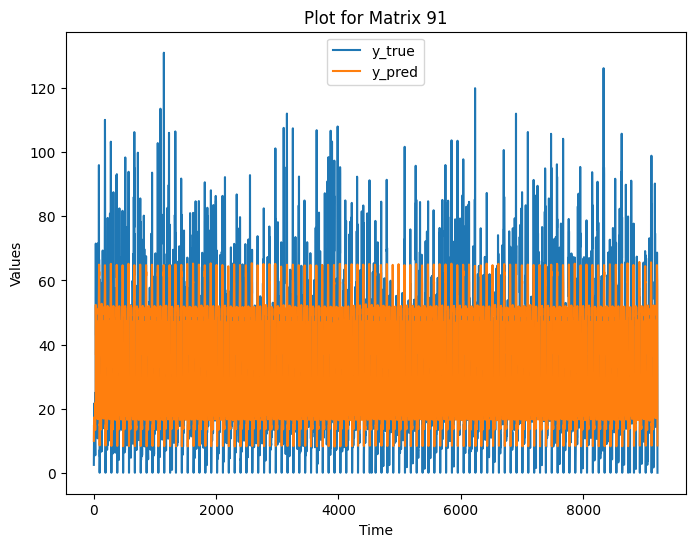

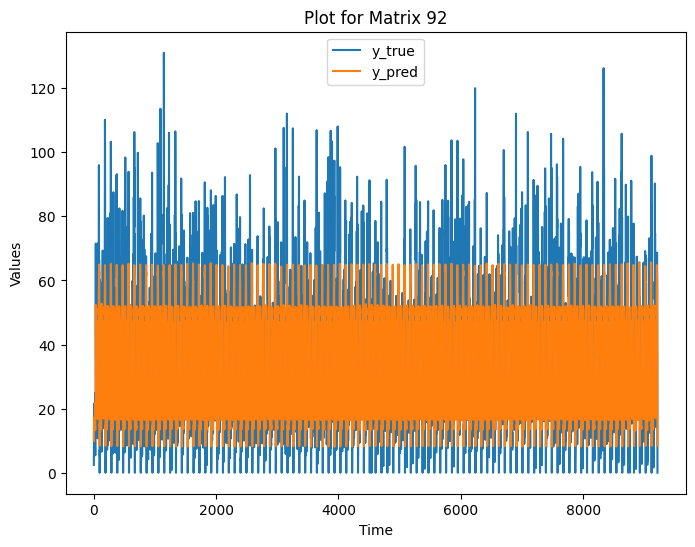

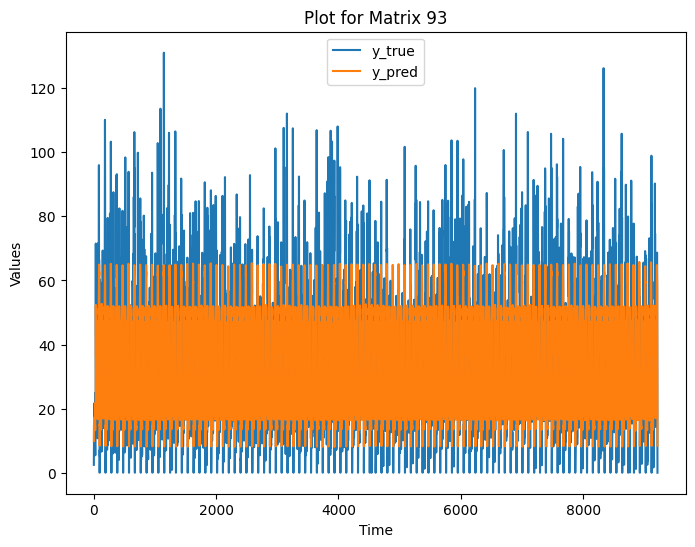

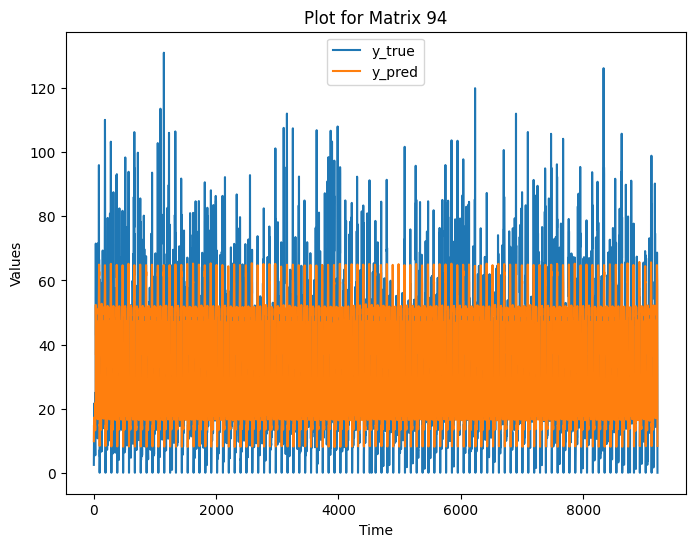

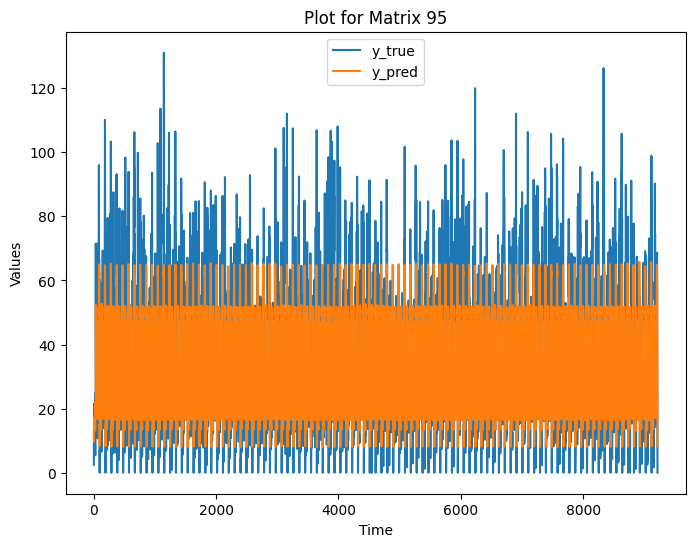

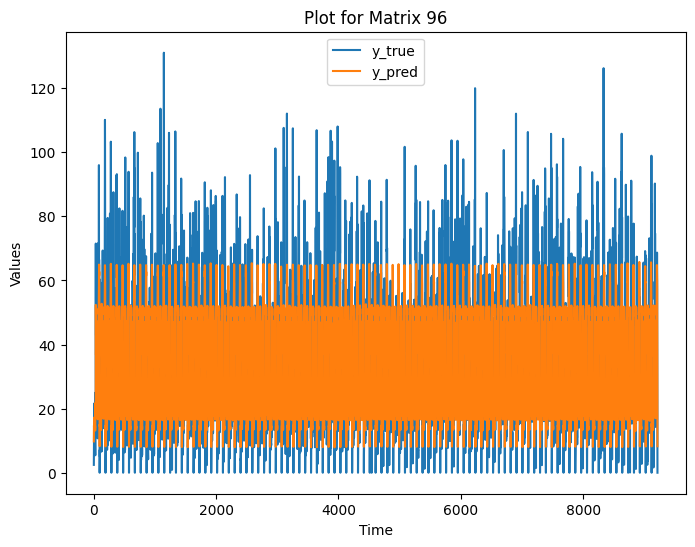

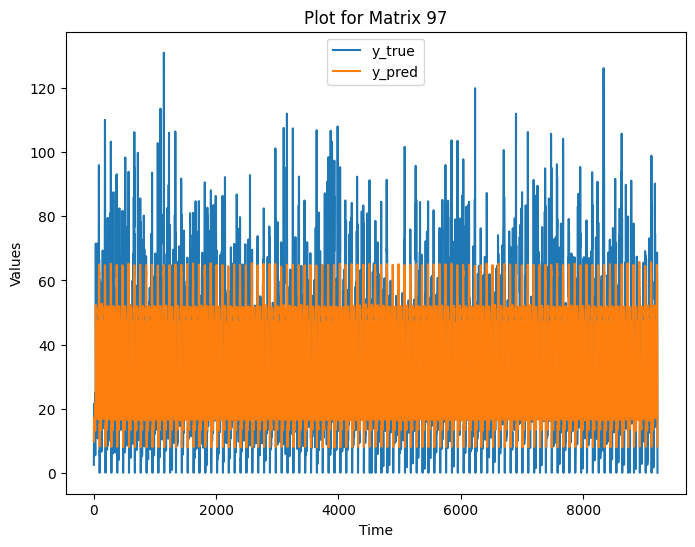

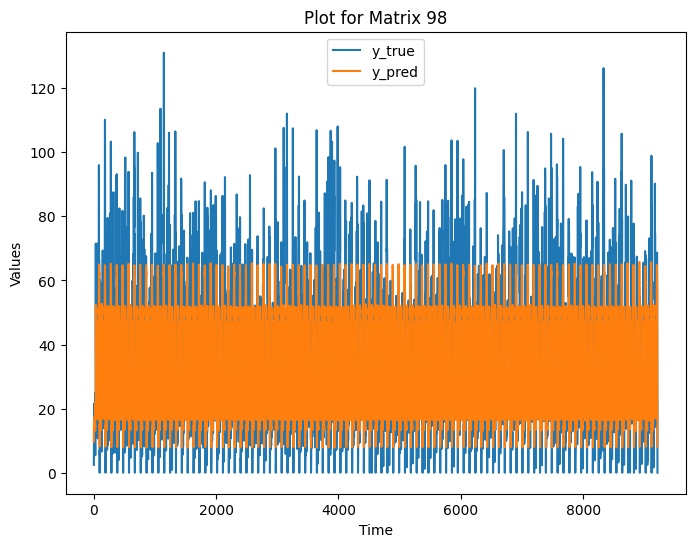

time: 49.7 s (started: 2023-11-11 22:15:05 +00:00)


In [54]:
#Plot showing y_pred compared to y_true for each round(epoch) for training

import matplotlib.pyplot as plt




# Create a function to plot a single matrix
def plot_matrix(matrix, idx):
    plt.figure(figsize=(8, 6))
    plt.plot(np.ravel(matrix[:, :, 1]), label='y_true')
    plt.plot(np.ravel(matrix[:, :, 0]), label='y_pred')

    plt.title(f'Plot for Matrix {idx + 1}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

# Iterate through the list of matrices and plot them
for idx, matrix in enumerate(y_true_y_pred_list):
    plot_matrix(matrix, idx)

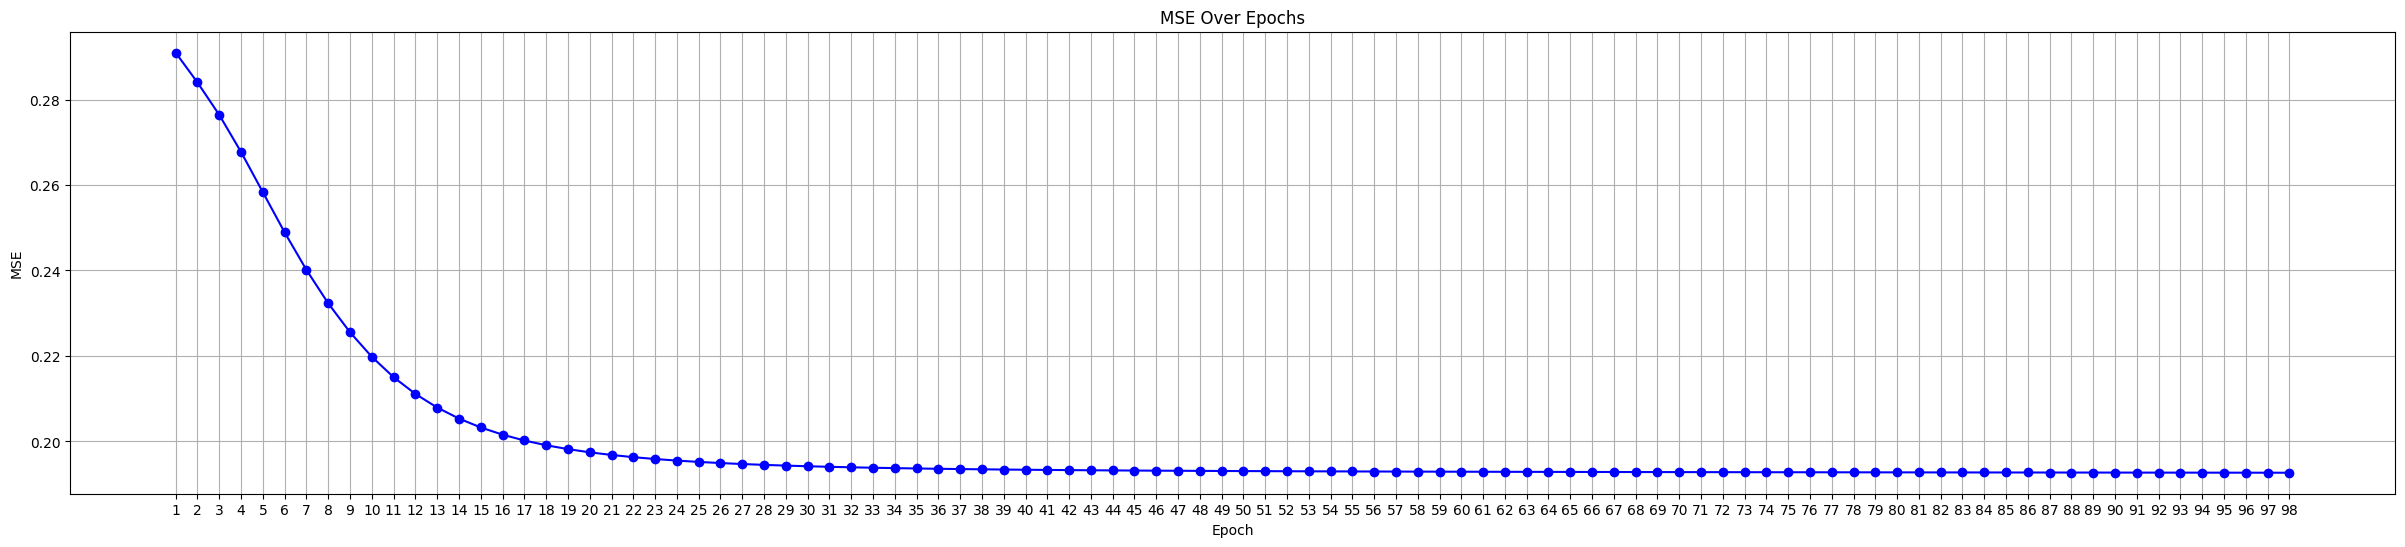

time: 914 ms (started: 2023-11-11 22:17:39 +00:00)


In [55]:
#Plot showing MSE for training


#Plot showing MSE for training

import matplotlib.pyplot as plt

# Assuming you have a list of MSE values (replace this with your actual list)


# Generate x-axis labels (e.g., epoch numbers or any other relevant labels)
epoch_labels = [f'{i+1}' for i in range(len(mse_list))]

# Plot the accuracy values
plt.figure(figsize=(30, 6))
plt.plot(epoch_labels, mse_list, marker='o', linestyle='-', color='b')

# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE Over Epochs')

# Show the plot
plt.grid(True)
plt.show()

In [57]:
#Reset config corectly for testing
NUM_CLIENTS = len(input_data_list_train)
NUM_EPOCHS = 1
BATCH_SIZE = 1
SHUFFLE_BUFFER = 1
PREFETCH_BUFFER = 1
class get_true_pred(tf.keras.metrics.Metric):
    def __init__(self, name='get_true_pred', **kwargs):
        super(get_true_pred, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', shape=(BATCH_SIZE, OUTPUT_SIZE, 2), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        values = tf.cast(y_pred, 'float32'), tf.cast(y_true, 'float32')
        values = tf.stack(values, axis=-1)
        self.true_positives.assign_add(values)

    def result(self):
        return self.true_positives

    def reset_states(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))



def model_fn():
    keras_model = create_keras_model2()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError(),get_true_pred()])

evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)

time: 1.37 s (started: 2023-11-11 22:18:23 +00:00)


In [58]:

#initialize test process
evaluation_state = evaluation_process.initialize()
model_weights = training_process.get_model_weights(train_state)
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)



time: 163 ms (started: 2023-11-11 22:18:29 +00:00)


In [59]:
#Test data
input_data_list_train=[prediction_processed_data[i][2].numpy() for i in range(50)]
target_data_list_train=[prediction_processed_data[i][3].numpy() for i in range(50)]




# Create a tf.data.Dataset from the testdata
def create_tf_dataset(input_data, target_data):
    dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
    return dataset

# Create client datasets
client_datasets = []
for i in range(NUM_CLIENTS):
    dataset = create_tf_dataset(input_data_list_train[i], target_data_list_train[i])
    dataset = dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
        BATCH_SIZE).prefetch(PREFETCH_BUFFER)
    client_datasets.append(dataset)

federated_test_data = client_datasets
#Evaluate on test data
evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

time: 19.4 s (started: 2023-11-11 22:18:31 +00:00)


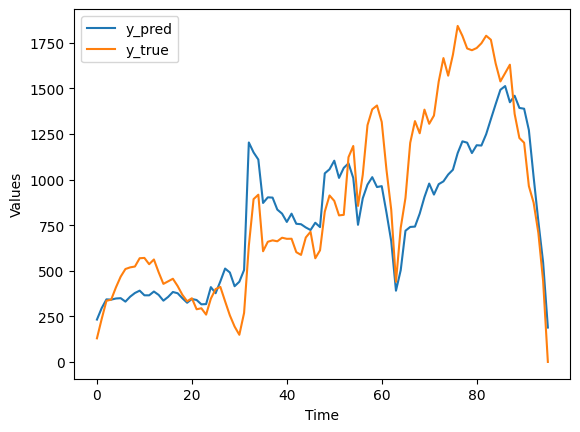

time: 203 ms (started: 2023-11-11 22:18:54 +00:00)


In [60]:
#Plot of y_pred and y_true for test

evaluation_output[1]
evaluation_metrices_dict = evaluation_output[1]['client_work']['eval']['total_rounds_metrics']
evaluation_metrices =evaluation_metrices_dict["get_true_pred"]




# Create a figure and axis
fig, ax = plt.subplots()

# Plot y_pred as the first series
ax.plot(np.ravel(evaluation_metrices[:,:,0]), label='y_pred')

# Plot y_true as the second series
ax.plot(np.ravel(evaluation_metrices[:,:,1]), label='y_true')

# Add labels and legend
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.legend()

# Show the plot
plt.show()


In [61]:
#accuracy for test

print(evaluation_metrices_dict['mean_squared_error'])

0.22811523
time: 1.38 ms (started: 2023-11-11 22:19:00 +00:00)
